In [7]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy

In [ ]:
# Tweaking $PYTHONPATH so we find TOMOPROXY
import sys
import os, glob
sys.path.append('../')

In [ ]:
# Importing tomoproxy modules
import tomoproxy.plotting
import tomoproxy.sh_tools
import tomoproxy.geody_compare as gc
import tomoproxy.layered_model as lm

import burnman

In [3]:
# List of Compositions, pPv Scenarios and Mineralogical Models
comp_list = ['pyrolite', 'BMO', 'MORB', 'HC']
ppv_list = ['noppv', 'ppv', 'partppv']
min_model_list = ['SLB_2022', 'SLB_2011']

In [4]:
# Output figure
output_figure = True
outdir = '../../plots/ppv_paper_figs/'

In [8]:
# Read input file
input_path = '../../data/D12_models/'

# depth
depth = np.loadtxt(input_path + 'D12_4000_depth_layers.dat')[:,1]
depth = depth[14:] # Truncate upper mantle layers

# coordinates
coords = np.loadtxt(input_path + 'D12_4000_lonlat.dat')
lon = coords[:,0] % 360
lat = coords[:,1]

In [9]:
# Input and create Layers
i = 1

t_grid = {'TC': np.zeros((len(depth),len(lat))),
          'TH': np.zeros((len(depth),len(lat)))}
comp_grid = np.zeros_like(t_grid['TC'])

for filename in glob.glob(os.path.join(input_path, 'D12-TC_4000/*.dat')):
    loc = int(os.path.splitext(filename)[0].split('_')[-1]) - 1
    if loc >= 14:
        data1 = np.loadtxt(filename)
        loc -= 14
    else:
        continue

    t_grid['TC'][loc] = data1[:,0]
    comp_grid[loc] = data1[:,2]
    i += 1

for filename in glob.glob(os.path.join(input_path, 'D12-TH_4000/*.dat')):
    loc = int(os.path.splitext(filename)[0].split('_')[-1]) - 1
    if loc >= 14:
        data1 = np.loadtxt(filename)
        loc -= 14
    else:
        continue

    t_grid['TH'][loc] = data1[:,0]
    i += 1

In [10]:
# Create properties for compositions
def find_comp_properties(comp):
    comp_all = ['pyrolite', 'pyroliteTC', 'BMO', 'MORB', 'HC']
    comp_index = comp_all.index(comp)
    t_grid = ['TH', 'TC', 'TC', 'TC', 'TC']
    X = [None, None, comp_grid, comp_grid, comp_grid]

    return t_grid[comp_index], X[comp_index]

In [ ]:
# Functions to run calculations
def seismic_sshells_200(fileloc, comp, ppv_model_type, min_model = '', seismic_model = ''):
    filename = os.path.join(fileloc, f'SH_{seismic_model}_{comp}_{ppv_model_type}_{min_model[-2:]}')

    Vp_layer = lm.LayeredModel(f'{filename}_Vp')
    Vs_layer = lm.LayeredModel(f'{filename}_Vs')
    Vphi_layer = lm.LayeredModel(f'{filename}_Vc')
    
    if comp != 'pyrolite':
        Vp_TH = lm.LayeredModel(f'{filename}_Vp'.replace(comp, 'pyrolite'))
        Vs_TH = lm.LayeredModel(f'{filename}_Vs'.replace(comp, 'pyrolite'))
        Vphi_TH = lm.LayeredModel(f'{filename}_Vc'.replace(comp, 'pyrolite'))

        depths_above_200 = [i for i, l in enumerate(Vp_layer.layers) if l.depth < (2891 - 200)]
        for d in depths_above_200:
            Vp_layer.layers[d].cilm[:] = Vp_TH.layers[d].cilm[:]
            Vs_layer.layers[d].cilm[:] = Vs_TH.layers[d].cilm[:]
            Vphi_layer.layers[d].cilm[:] = Vphi_TH.layers[d].cilm[:]

    return Vp_layer, Vs_layer, Vphi_layer

    
def gridded_data(lon, lat, data):
    if max(lon) > 180:
        lon = ((lon+180)%360)-180
    interpolator = scipy.interpolate.NearestNDInterpolator((lon, lat), data, rescale=False)
    y, x = np.meshgrid(np.linspace(-90,90,181), np.linspace(-180,180,361))
    trial = interpolator(x, y)
    return x, y, trial


def rms(array, ax = None, type = None):
    if type == "SH":
        return np.sqrt(np.sum((array ** 2) / (4 * np.pi), axis = ax))
    else:
        return np.sqrt(np.sum((array ** 2) / np.size(array), axis = ax))

In [ ]:
# Functions to plot graphs
def plot_two_phase_region(temperatures, phaseboundary, t_grid, min_model='SLB_2022', output_figure=True):

    """
    Plots the two phase region of the bridgmanite post-perovskite phase transition, separated into
    thermal and thermochemical compositions.
    """
    
    CMB = burnman.seismic.PREM().pressure([2890*1000]) / 1e9
    
    fig, ax = plt.subplots(1, 2, figsize = (14,10), sharey = True)
    fig.subplots_adjust(wspace = 0)
    depth_to_pressure = burnman.seismic.PREM().pressure(depth*1000)/1e9

    t_mean = np.mean(t_grid['TH'], axis = 1)
    t_err = np.percentile(t_grid['TH'], [10, 90], axis = 1)
    ax[0].plot(t_mean, depth_to_pressure, 'k')
    ax[0].plot(t_err[0], depth_to_pressure, 'k--')
    ax[0].plot(t_err[1], depth_to_pressure, 'k--')
    ax[0].fill_between(temperatures, 
                    phaseboundary[f'pyrolite_{min_model[-2:]}'].lowp/1e9, 
                    phaseboundary[f'pyrolite_{min_model[-2:]}'].highp/1e9, 
                    color = 'b', alpha = 0.5, label = 'Pyrolite')
    ax[0].axhline(CMB, c = 'maroon', linewidth = 5)
    ax[0].set_xlim([1000,4500])
    ax[0].set_ylim([150, 80])
    ax[0].tick_params(axis='both', labelsize = 15)
    ax[0].legend(fontsize = 15, framealpha = 0)
    ax[0].set_xlabel('Temperature (K)', fontsize = 15)
    ax[0].set_ylabel('Pressure (GPa)', fontsize = 15)
    ax[0].set_xticklabels(ax[0].get_xticklabels()[:-1], fontsize = 15)
    ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = 15)
    ax[0].tick_params(axis='both', labelsize = 15)

    tC_mean = np.mean(t_grid['TC'], axis = 1)
    tC_err = np.percentile(t_grid['TC'], [10, 90], axis = 1)
    ax[1].plot(tC_mean, depth_to_pressure, 'k')
    ax[1].plot(tC_err[0], depth_to_pressure, 'k--')
    ax[1].plot(tC_err[1], depth_to_pressure, 'k--')
    for comp, c in zip(['BMO', 'MORB', 'HC'], ['r', 'orange', 'y']):
        ax[1].fill_between(temperatures, 
                           phaseboundary[f'{comp}_{min_model[-2:]}'].lowp/1e9, 
                           phaseboundary[f'{comp}_{min_model[-2:]}'].highp/1e9, 
                           color = c, alpha = 0.5, label = comp)
    ax[1].axhline(CMB, c = 'maroon', linewidth = 5)
    ax[1].set_xlim([1000,4500])
    ax[1].legend(fontsize = 15, framealpha = 0)
    ax[1].set_xlabel('Temperature (K)', fontsize = 15)
    ax[1].tick_params(axis='both', labelsize = 15)

    title_extension = ''
    if min_model == "SLB_2011":
        title_extension = ' using SLB2011'

    fig.suptitle(f'Bridgmanite-Post-perovskite phase boundary{title_extension}', fontsize = 23, y = 0.96)
    ax[0].set_title('Thermal', fontsize = 18)
    ax[1].set_title('Thermochemical', fontsize = 18)

    ax2 = ax[1].twinx()
    ax2.set_ylim(ax[1].get_ylim())
    ax2.set_yticks(burnman.seismic.PREM().pressure(np.array([2000,2200,2400,2600,2800,2890])*1000) / 1e9, 
                   labels = ['2000', '2200', '2400','2600','2800', '2890'], fontsize = 15)
    ax2.set_ylabel('Depth (km)', fontsize = 15)

    if output_figure:
        fig.savefig(os.path.join(outdir, f"two_phase_{min_model.replace('SLB_', '')}.png"), 
                    transparent = True, bbox_inches = 'tight')


def plot_SOLA_model(SOLA_model, titlesize = 35, labelsize = 22, ticklabelsize = 15):

    """
    Plots the resolving kernel, mean and uncertainties of $V_p$ and $V_s$ of the SOLA model.
    """

    fig, ax = plt.subplots(3,3, figsize = (29, 17), width_ratios=[1.5, 6, 6], height_ratios=[6,6,1], subplot_kw = dict(projection = ccrs.Robinson(central_longitude=150)))


    tomoproxy.plotting.plot_shcoefs(SOLA_model.vp, quantity = f'dlnV$_p$ (%)', cmap = 'RdBu',
                                        show_cb=False,
                                        fig = fig,
                                        ax = ax[1,1],
                                        vmin = -0.5, vmax = 0.5, projection = ccrs.Robinson())
    tomoproxy.plotting.plot_shcoefs(SOLA_model.vs, quantity = f'dlnV$_s$ (%)', cmap = 'RdBu',
                                        show_cb=False,
                                        fig = fig,
                                        ax = ax[0,1],
                                        vmin = -1.0, vmax = 1.0, projection = ccrs.Robinson())

    tomoproxy.plotting.plot_err_coefs(SOLA_model.vp_err, quantity='$\sigma$ V$_p$',
                                show_cb=False,
                                fig = fig,
                                coast_color='k',
                                ax = ax[1,2],
                                vmax = 0.25, projection=ccrs.Robinson())
    tomoproxy.plotting.plot_err_coefs(SOLA_model.vs_err, quantity='$\sigma$ V$_s$',
                                show_cb=False,
                                coast_color='k',
                                fig = fig,
                                ax = ax[0,2],
                                vmax = 0.25, projection=ccrs.Robinson())

    ax[0,1].set_title('(b) Mean Model', fontsize = titlesize, y = 1.05)
    ax[0,2].set_title('(c) Uncertainties', fontsize = titlesize, y = 1.05)

    ax[1,1].set_xlabel('dlnV$_p$ (±0.5%)', fontsize = 1.3*labelsize, y = 0.98)
    ax[0,1].set_xlabel('dlnV$_s$ (±1.0%)', fontsize = 1.3*labelsize, y = 0.98)
    ax[1,1].set_xticks([])
    ax[0,1].set_xticks([])

    ax[1,2].set_xlabel('$\sigma$ V$_p$', fontsize = 1.3*labelsize, y = 0.98)
    ax[0,2].set_xlabel('$\sigma$ V$_s$', fontsize = 1.3*labelsize, y = 0.98)
    ax[1,2].set_xticks([])
    ax[0,2].set_xticks([])

    ax[-1,1] = plt.subplot(3,3,8, projection = 'rectilinear')
    seismic_cb = plt.cm.ScalarMappable(cmap = 'RdBu')
    seismic_cb.set_clim(-1,1)
    h = fig.colorbar(seismic_cb, cax = ax[-1,1], orientation = 'horizontal', ticks = [-1, 0, 1], spacing = 'proportional', extend = 'both')
    h.set_label('Velocity (%) with respect to radial average', size=labelsize)
    h.ax.set_xticklabels(['Lower', '0', 'Higher'], fontsize = ticklabelsize)

    ax[-1,2] = plt.subplot(3,3,9, projection = 'rectilinear')
    grey_cb = plt.cm.ScalarMappable(cmap = 'Greys')
    grey_cb.set_clim(0, 0.25)
    h2 = fig.colorbar(grey_cb, cax = ax[-1,2], orientation = 'horizontal', spacing = 'proportional', extend = 'max')
    h2.set_label('Velocity anomaly uncertainty (%)', size=labelsize)
    h2.ax.tick_params(labelsize = ticklabelsize)

    ax[0,0] = plt.subplot(3,3,(1,4), projection = 'rectilinear')
    ax[0,0].axvline(0, c = 'silver')
    ax[0,0].plot(SOLA_model.spline_vp, 6371 - SOLA_model.depths, 'b', linewidth = 2, label = 'd$\ln V_p$')
    ax[0,0].plot(SOLA_model.spline_vs, 6371 - SOLA_model.depths, 'r', linewidth = 2, label = 'd$\ln V_s$')
    ax[0,0].set_ylabel('Depth (km)', fontsize= labelsize)
    ax[0,0].set_ylim([2900, 0])
    ax[0,0].set_xlim([-0.02,0.07])
    ax[0,0].set_xticks([])
    ax[0,0].tick_params(axis = 'both', labelsize = ticklabelsize)
    ax[0,0].legend(fontsize = ticklabelsize)
    ax[0,0].set_title('(a) Resolution', fontsize = titlesize, y = 1.01)

    ax[-1,0].axis('off')

    return fig


def plot_filtered_synthetic_models(SOLA_model, synthetic_models, 
                                   v_type, cbar_lim, min_model, 
                                   central_longitude = 0, 
                                   plot_type = 'presentation', 
                                   outdir = ''):
    
    """
    Plots filtered synthetic velocity models, organised by post-perovskite stability
    scenario and LLVP composition.
    """

    assert v_type in ['vp', 'vs', 'vphi'], "Not valid velocity type"

    if plot_type == 'presentation':
        fig, ax = plt.subplots(4, 4, figsize = (23,13), subplot_kw = dict(projection = ccrs.Robinson(central_longitude = central_longitude)))
        fontsize = 25
        labelsize = 15
        ticklabelsize = 13
        fig.subplots_adjust(wspace = 0.08, hspace = 0.08)
        start_row = 0
        cb_orientation = 'vertical'
    else:
        fig, ax = plt.subplots(6, 3, figsize = (15,16), height_ratios=[6,6,6,6,6,1], subplot_kw = dict(projection = ccrs.Robinson(central_longitude = central_longitude)))
        fontsize = 20
        labelsize = 15
        ticklabelsize = 10
        start_row = 1
        cb_orientation = 'horizontal'

    # For plotting titles
    LLVP_comp = ["Pyrolite", "MORB", "BMO", "HC"]
    ppv_scenario = ["No pPv", "pPv", "Partial pPv"]

    # for dictionary keys
    comp_list = ['pyrolite', 'MORB', 'BMO', 'HC']
    ppv_list = ['noppv', 'ppv', 'partppv']

    # Declaring special axes for BG model and colorbars
    if plot_type == 'presentation':
        v_axis = plt.subplot(8,4, (8,12), projection = ccrs.Robinson(central_longitude = central_longitude))
        sigma_axis = plt.subplot(8,4, (16,20), projection = ccrs.Robinson(central_longitude = central_longitude))
        cb_v_axis = plt.subplot(8, 24, (140,188), projection = 'rectilinear')
        cb_sigma_axis = plt.subplot(8, 24, (143,191), projection = 'rectilinear')
    else:
        # fig.suptitle("V$_s$ slices for SLB 2022", fontsize = 4/3 * fontsize, y = 0.93)
        v_axis = plt.subplot(6,6, (2,3), projection = ccrs.Robinson(central_longitude = central_longitude))
        sigma_axis = plt.subplot(6,6, (4,5), projection = ccrs.Robinson(central_longitude = central_longitude))
        cb_v_axis = plt.subplot(6,3,(16,17), projection = 'rectilinear')
        cb_sigma_axis = plt.subplot(6,3,18, projection = 'rectilinear')

    tomoproxy.plotting.plot_shcoefs(getattr(SOLA_model, v_type), quantity = f'dlnV$_{v_type[1:]}$ (%)', cmap = 'RdBu',
                                        show_cb=False,
                                        fig = fig,
                                        ax = v_axis,
                                        vmin = -cbar_lim, vmax = cbar_lim, projection = ccrs.Robinson())
    v_axis.set_title('SOLA Mean Model', fontsize = fontsize)
    tomoproxy.plotting.plot_err_coefs(getattr(SOLA_model, v_type+'_err'), quantity = f'$\sigma$ V$_{v_type[1:]}$ (%)',
                                        show_cb=False,
                                        coast_color='k',
                                        fig = fig,
                                        ax = sigma_axis,
                                        vmax = 0.25, projection=ccrs.Robinson())
    sigma_axis.set_title('SOLA Model Uncertainties', fontsize = fontsize)

    for name, m in synthetic_models.items():
        split_name = name.split('_')
        comp = split_name[0]
        ppv = split_name[1]

        comp_index = comp_list.index(comp)
        ppv_index = ppv_list.index(ppv)

        if split_name[2] == min_model[-2:]:
            tomoproxy.plotting.plot_shcoefs(getattr(m, v_type), quantity = f'dV$_{v_type[1:]}$ (%)', cmap = 'RdBu',
                                            fig = fig,
                                            ax = ax[start_row + comp_index, ppv_index],
                                            vmin = -cbar_lim, vmax = cbar_lim, show_cb = False, projection = ccrs.Robinson())

    for i, axes in enumerate(ax[start_row, :len(ppv_scenario)]):
        axes.set_title(f'{ppv_scenario[i]}', fontsize = fontsize)
    for i, axes in enumerate(ax[start_row:start_row + len(LLVP_comp),0]):
        axes.set_ylabel(f'{LLVP_comp[i]}', fontsize = fontsize)
        axes.set_yticks([])

    trans = ax[0,0].get_transform()
    ax[0,0].plot([0,0],[10,10], color="k", transform=trans, clip_on=False)


    seismic_cb = plt.cm.ScalarMappable(cmap = 'RdBu')
    seismic_cb.set_clim(-cbar_lim, cbar_lim)
    h = fig.colorbar(seismic_cb, cax = cb_v_axis, orientation = cb_orientation, extend = 'both')
    h.set_label(f'dlnV$_{v_type[1:]}$ (%)', size=labelsize)
    h.ax.tick_params(labelsize = ticklabelsize)
    grey_cb = plt.cm.ScalarMappable(cmap = 'Greys')
    grey_cb.set_clim(0, 0.25)
    h2 = fig.colorbar(grey_cb, cax = cb_sigma_axis, orientation = cb_orientation, spacing = 'proportional', extend = 'max')
    h2.set_label(f'dlnV$_{v_type[1:]}$ uncertainty (%)', size=labelsize)
    h2.ax.tick_params(labelsize = ticklabelsize)
    if output_figure:
        fig.savefig(outdir + f'v{v_type[1:]}_{min_model[-2:]}.png', transparent = True)
        fig.savefig(outdir + f'v{v_type[1:]}_{min_model[-2:]}.eps', transparent = True)


def plot_RMS_velocities(ppv_frac, synthetic_models,
                         vp_median, vs_median, 
                         vp_bounds_1, vs_bounds_1, 
                         vp_bounds_2, vs_bounds_2, 
                         min_model='SLB_2022', outdir='', thermochemical_bottom=False):
    
    """
    Plotting RMS dln velocities
    """

    assert min_model in ['SLB_2011', 'SLB_2022'], "Database not recognised. Must either be 2022 (SLB 2022) or 2011 (SLB 2011)"

    suptitlesize = 16
    titlesize = 14
    labelsize = 11

    fig, ax = plt.subplots(1, 2, figsize = (9,6), sharex = True)
    fig.subplots_adjust(wspace = 0.25)
    comp_order_ppv = ['b', 'r', 'orange', 'y']
    marker= ['x','P','o']
    
    comp_list = ['pyrolite', 'BMO', 'MORB', 'HC']
    ppv_list = ['noppv', 'ppv', 'partppv']

    # Plot SOLA values + sigma uncertainties
    lims = [-0.05, 0.85]
    # lims = [-0.5, 3.5]
    ax[0].axhline(vp_median, c='k')
    ax[0].fill_between(lims, vp_bounds_2[0] * np.ones(2), vp_bounds_2[1] * np.ones(2), color = (0.9, 0.9, 0.9, 1))
    ax[0].fill_between(lims, vp_bounds_1[0] * np.ones(2), vp_bounds_1[1] * np.ones(2), color = (0.8, 0.8, 0.8, 1))
    ax[1].axhline(vs_median, c='k')
    ax[1].fill_between(lims, vs_bounds_2[0] * np.ones(2), vs_bounds_2[1] * np.ones(2), color = (0.9, 0.9, 0.9, 1))
    ax[1].fill_between(lims, vs_bounds_1[0] * np.ones(2), vs_bounds_1[1] * np.ones(2), color = (0.8, 0.8, 0.8, 1))

    # Only plotting newest database
    if min_model == 'SLB_2022':
        data_title = ''
    elif min_model == 'SLB_2011':
        data_title = ' using SLB2011'

    # for bottommost 200km thermochemical scenario
    if thermochemical_bottom:
        TC_title = ' of depth-restricted thermochemical LLVPs'
        TC_filename = '_200'
    else:
        TC_title = ''
        TC_filename = ''
        
    for name, m in synthetic_models.items():
        split_name = name.split('_')
        comp = split_name[0]
        ppv = split_name[1]

        comp_index = comp_list.index(comp)
        ppv_index = ppv_list.index(ppv)

        if split_name[2] == min_model[-2:]:    
            ax[0].scatter(ppv_frac[name], rms(m.vp, type = 'SH'), c = comp_order_ppv[comp_index], marker = marker[ppv_index])
            ax[1].scatter(ppv_frac[name], rms(m.vs, type = 'SH'), c = comp_order_ppv[comp_index], marker = marker[ppv_index])
            # ax[0].scatter(comp_index, rms(m.vp, type = 'SH'), c = comp_order_ppv[comp_index], marker = marker[ppv_index])
            # ax[1].scatter(comp_index, rms(m.vs, type = 'SH'), c = comp_order_ppv[comp_index], marker = marker[ppv_index])

    # Titles and labels
    ax[0].set_ylabel('(a) dlnV$_p$ (%)', fontsize = labelsize)
    ax[1].set_ylabel('(b) dlnV$_s$ (%)', fontsize = labelsize)
    ax[1].set_xlim([-0.05, 0.85])
    fig.text(0.5, 0.04, 'Measure of bdg-pPv co-occurrence', horizontalalignment='center', fontsize = labelsize)
    fig.suptitle(f'RMS velocities{TC_title}{data_title}', y = 0.97, fontsize = suptitlesize)
    ax[0].set_title('dlnV$_p$', fontsize = titlesize)
    ax[1].set_title('dlnV$_s$', fontsize = titlesize)
    # ax[0].set_xticks([0,1,2,3], comp_list)
    # ax[1].set_xticks([0,1,2,3], comp_list)
    # ax[1].set_xlim([-0.5, 3.5])
    # fig.text(0.5, 0.04, 'LLVP Composition', horizontalalignment='center', fontsize = labelsize)
    # fig.suptitle(f'RMS velocities{TC_title}{data_title}', y = 0.97, fontsize = suptitlesize)

    # Legend
    ax[1].scatter([-1,-1],[0.5,0.5], label = '$\\bf{pPv}$ $\\bf{Model}$', c = 'none')
    ax[1].scatter([-1,-1],[0.5,0.5], label = 'No pPv', c = 'k', marker = marker[0])
    ax[1].scatter([-1,-1],[0.5,0.5], label = 'Partial pPv', c = 'k', marker = marker[1])
    ax[1].scatter([-1,-1],[0.5,0.5], label = 'pPv', c = 'k', marker = marker[2])
    ax[1].scatter([-1,-1],[0.5,0.5], label = '\n$\\bf{LLVP}$ $\\bf{Comp}$.', c = 'none')
    ax[1].scatter([-1,-1],[0.5,0.5], label = 'Pyrolite', c = 'b')
    ax[1].scatter([-1,-1],[0.5,0.5], label = 'BMO', c = 'r')
    ax[1].scatter([-1,-1],[0.5,0.5], label = 'MORB', c = 'orange')
    ax[1].scatter([-1,-1],[0.5,0.5], label = 'HC', c = 'y')

    # Right center legend
    fig.legend(loc = 'center right', bbox_to_anchor = (1.07, 0.5),fontsize = 10)

    if output_figure:
        fig.savefig(os.path.join(outdir, f'rms_velocity_{min_model[-2:]}{TC_filename}.png'), transparent = True, bbox_inches = 'tight')
        fig.savefig(os.path.join(outdir, f'rms_velocity_{min_model[-2:]}{TC_filename}.eps'), transparent = True, bbox_inches = 'tight')


def plot_ratios_and_corr(ppv_frac, Rsp, rsc, 
                         R_median, corr_median, 
                         r_bounds_1, corr_bounds_1, 
                         r_bounds_2, corr_bounds_2, 
                         min_model='SLB_2022', output_type='poster'):
    
    """
    Plots the ratio $R_{s/p}$ and correlation $r_{s–c}$.
    """
    
    separate_columns = False
    assert min_model in ['SLB_2011', 'SLB_2022'], "Database not recognised. Must either be 2022 (SLB 2022) or 2011 (SLB 2011)"

    if output_type == 'presentation':
        titlesize = 15
        labelsize = 15
        ticklabelsize = 12
        legendsize = 10
        size = 70
        fig, ax = plt.subplots(1,2, figsize = (9.5,6), sharex = True)
    else:
        suptitlesize = 15
        titlesize = 13
        labelsize = 12
        ticklabelsize = 10
        legendsize = 8
        size = 50
        fig, ax = plt.subplots(1,2, figsize = (10.1,6), sharex = True)
    fig.subplots_adjust(wspace = 0.35)

    edgesize = 1.7

    comp_order_ppv = ['b', 'b', 'b', 'r', 'r', 'r', 'orange', 'orange', 'orange', 'y', 'y', 'y']
    m_keys = ['pyrolite_noppv', 'pyrolite_ppv', 'pyrolite_partppv', 'BMO_noppv', 'BMO_ppv', 'BMO_partppv', 
            'MORB_noppv', 'MORB_ppv', 'MORB_partppv', 'HC_noppv', 'HC_ppv', 'HC_partppv']
    m= ['x','P','o']

    # Plotting Model
    lims = [-0.15, 0.95]
    # lims = [-0.5, 3.5]
    ax[0].axhline(R_median, c = 'k')
    ax[0].fill_between(lims, r_bounds_2[0] * np.ones(2), r_bounds_2[1] * np.ones(2), color = (0.9, 0.9, 0.9, 1))
    ax[0].fill_between(lims, r_bounds_1[0] * np.ones(2), r_bounds_1[1] * np.ones(2), color = (0.8, 0.8, 0.8, 1))
    ax[1].axhline(corr_median, c = 'k')
    ax[1].fill_between(lims, corr_bounds_2[0] * np.ones(2), corr_bounds_2[1] * np.ones(2), color = (0.9, 0.9, 0.9, 1))
    ax[1].fill_between(lims, corr_bounds_1[0] * np.ones(2), corr_bounds_1[1] * np.ones(2), color = (0.8, 0.8, 0.8, 1))

    # make inset axis
    zm = ax[1].inset_axes([0,-0.7, 0.45, 1.2], transform=ax[1].transData)
    zm.set_xlim([0.78, 0.82])
    if min_model == 'SLB_2022':
        zm.set_ylim([-0.90, -0.78])
    elif min_model == 'SLB_2011':
        zm.set_ylim([-0.93, -0.78])

    zm.set_facecolor((0.97, 0.97, 0.97, 1))
    zm.set_xticks([])
    zm.set_yticks([])
    zm.fill_between(lims, corr_bounds_2[0] * np.ones(2), corr_bounds_2[1] * np.ones(2), color = (0.9, 0.9, 0.9, 1))

    ax[1].indicate_inset_zoom(zm, edgecolor = 'black')

    # Only plotting newest database
    if min_model == 'SLB_2022':
        start = 0
        data_title = ''
    elif min_model == 'SLB_2011':
        start = 12
        data_title = ' using SLB2011'

    for i, (c, k) in enumerate(zip(comp_order_ppv, m_keys)):
        ax[0].scatter(ppv_frac[k+f'_{min_model[-2:]}'], Rsp[start+i,0], c = c, marker = m[i%3], linewidth = edgesize, s = size)
        ax[1].scatter(ppv_frac[k+f'_{min_model[-2:]}'], rsc[start+i,0], c = c, marker = m[i%3], linewidth = edgesize, s = size)
        zm.scatter(ppv_frac[k+f'_{min_model[-2:]}'], rsc[start+i,0], c = c, marker = m[i%3], linewidth = edgesize, s = size)

    # for i, c in enumerate(comp_order_ppv):
    #     ax[0].scatter(int(np.floor(i/3)), Rsp[start+i,0], c = c, marker = m[i%3], linewidth = edgesize, s = size)
    #     ax[1].scatter(int(np.floor(i/3)), rsc[start+i,0], c = c, marker = m[i%3], linewidth = edgesize, s = size)
       
    ax[0].set_ylabel('$R_{s/p}$', fontsize = labelsize)
    ax[1].set_ylabel('$r_{s–c}$', fontsize = labelsize)

    #
    ax[0].set_title('(a) R$_{s/p}$', fontsize = titlesize)
    ax[1].set_title('(b) r$_{s–c}$', fontsize = titlesize)
    # ax[0].set_xticks([0,1,2,3], comp_list)
    # ax[1].set_xticks([0,1,2,3], comp_list)
    # ax[1].set_xlim([-0.5, 3.5])
    ax[1].set_xlim([-0.05, 0.85])
    ax[0].set_ylim([1.4, 4.2])
    ax[1].set_ylim([-1.05, 1.05])
    ax[0].tick_params(axis = 'both', which = 'major', labelsize = ticklabelsize)
    ax[1].tick_params(axis = 'both', which = 'major', labelsize = ticklabelsize)

    # Legend
    ax[1].scatter([-1,-1],[0,0], label = '$\\bf{pPv}$ $\\bf{Model}$', c = 'none')
    ax[1].scatter([-1,-1],[0,0], label = 'No pPv', c = 'k', marker = m[0])
    ax[1].scatter([-1,-1],[0,0], label = 'Partial pPv', c = 'k', marker = m[1])
    ax[1].scatter([-1,-1],[0,0], label = 'pPv', c = 'k', marker = m[2])
    ax[1].scatter([-1,-1],[0,0], label = '\n$\\bf{LLVP}$ $\\bf{Comp}$.', c = 'none')
    ax[1].scatter([-1,-1],[0,0], label = 'Pyrolite', c = 'b')
    ax[1].scatter([-1,-1],[0,0], label = 'BMO', c = 'r')
    ax[1].scatter([-1,-1],[0,0], label = 'MORB', c = 'orange')
    ax[1].scatter([-1,-1],[0,0], label = 'HC', c = 'y')

    # fig.suptitle('$R_{s/p}$ and $r_{s–c}$ for filtered models'+f'{data_title}', y = 0.93, fontsize = suptitlesize)
    fig.suptitle('$R_{s/p}$ and $r_{s–c}$ for filtered models'+f'{data_title}', y = 0.97, fontsize = suptitlesize)
    if output_type == 'presentation':
        fig.legend(loc = 'center right', bbox_to_anchor = (1.08, 0.5), fontsize = legendsize)
        figtext = 'Depth averaged pPv Fraction'
        # figtext = 'LLVP Composition'
    else:
        # fig.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.04), ncols = 9, fontsize = legendsize)
        fig.legend(loc = 'center right', bbox_to_anchor = (1.03, 0.5), fontsize = legendsize)
        figtext = 'Measure of bdg-pPv co-occurrence'
        # figtext = 'LLVP Composition'

    if separate_columns:
        ax[0].set_xlabel(figtext, fontsize = labelsize)
        ax[1].set_xlabel(figtext, fontsize = labelsize)
    else:
        fig.text(0.5, 0.03, figtext, horizontalalignment='center', fontsize = labelsize)

    if output_figure:
        fig.savefig(os.path.join(outdir, f'ratios_filtered_{min_model[-2:]}.png'), transparent = True, bbox_inches = 'tight', dpi = 500)
        fig.savefig(os.path.join(outdir, f'ratios_filtered_{min_model[-2:]}.eps'), transparent = True, bbox_inches = 'tight', dpi = 500)


In [ ]:
# Importing SOLA Tomographic Model
SOLA_path = "../../data/SOLA_model/"
SOLA_model = gc.SOLAShell.from_directory(SOLA_path)
SOLA_model.apply_kernel()

SOLA_model.vp = tomoproxy.sh_tools.rts_to_sh(SOLA_model.vp)
SOLA_model.vs = tomoproxy.sh_tools.rts_to_sh(SOLA_model.vs)
SOLA_model.vphi = tomoproxy.sh_tools.rts_to_sh(SOLA_model.vphi)
SOLA_model.vp_err = tomoproxy.sh_tools.rts_to_sh(SOLA_model.vp_err)
SOLA_model.vs_err = tomoproxy.sh_tools.rts_to_sh(SOLA_model.vs_err)
SOLA_model.vphi_err = tomoproxy.sh_tools.rts_to_sh(SOLA_model.vphi_err)

In [52]:
# Load realisation values of SOLA Tomographic Model
a = np.load(input_path + 'SOLA_model_realisations.npz',)
SOLA_Vp_layer_rand = a['vp_random']
SOLA_Vs_layer_rand = a['vs_random']
R_random = a['R_random']
corr_random = a['corr_random']

Vp_random = rms(SOLA_Vp_layer_rand, ax = (1,2,3), type = 'SH')
Vs_random = rms(SOLA_Vs_layer_rand, ax = (1,2,3), type = 'SH')
vp_median = np.median(Vp_random)
vp_bounds_1 = np.percentile(Vp_random, q = [16, 84])
vp_bounds_2 = np.percentile(Vp_random, q = [2.3, 97.7])
vs_median = np.median(Vs_random)
vs_bounds_1 = np.percentile(Vs_random, q = [16, 84])
vs_bounds_2 = np.percentile(Vs_random, q = [2.3, 97.7])

r_median = np.median(R_random)
r_bounds_1 = np.percentile(R_random, q = [16, 84])
r_bounds_2 = np.percentile(R_random, q = [2.3, 97.7])
corr_median = np.median(corr_random)
corr_bounds_1 = np.percentile(corr_random, q = [16, 84])
corr_bounds_2 = np.percentile(corr_random, q = [2.3, 97.7])

In [51]:
# Generating Unfiltered and Filtered Seismic Models
radial_degree = 20 

raw_velocity = {}
models = {}
for min_model in min_model_list:
    for comp in comp_list:
        for ppv in ppv_list:
            name = f'{comp}_{ppv}_{min_model[-2:]}'
            raw_velocity[name] = gc.RawSeismicModel.from_file(radial_degree, input_path, 
                                                        comp, ppv, min_model, seismic_model='SOLA')
            
            models[name] = raw_velocity[name].to_SOLA()
            models[name].apply_kernel()

In [65]:
# Generating Filtered Seismic Models for bottommost 200km case
radial_degree = 20
 
models_200 = {}
for min_model in min_model_list[:1]:
    for comp in comp_list:
        for ppv in ppv_list:
            name = f'{comp}_{ppv}_{min_model[-2:]}'

            Vp, Vs, Vc = seismic_sshells_200(input_path, comp, ppv, min_model, seismic_model='SOLA')
            raw_velocity_200 = gc.RawSeismicModel(Vp, Vs, Vc, radial_degree)
            
            models_200[name] = raw_velocity_200.to_SOLA()
            models_200[name].apply_kernel()

In [ ]:
# Calculate mean ppv fraction per depth layer in each model
ppv_state_all = {}
ppv_means = {}          # records mean ppv frac per depth layer per model
ppv_lateral_frac = {}   # records depth averaged ppv frac per model

for min_model in min_model_list:
    for comp in comp_list:  
        t, _ = find_comp_properties(comp)

        filename = os.path.join(input_path, f'phases_{comp}_{min_model[-2:]}.npz')
        phase = gc.PhaseGrid(filename, t_grid[t], depth, lon, lat, comp, min_model)
        py_phase = gc.PhaseGrid(filename.replace(comp, 'pyroliteTC'), t_grid['TC'], depth, lon, lat, 'pyroliteTC', min_model)

        ppv_state_all[f'{comp}_noppv_{min_model[-2:]}'] = np.zeros_like(t_grid[t])
        ppv_state_all[f'{comp}_ppv_{min_model[-2:]}'] = phase.calculate_ppv_frac(py_phase, comp_grid)
        ppv_state_all[f'{comp}_partppv_{min_model[-2:]}'] = phase.calculate_ppv_frac(py_phase, comp_grid, True)

for name, ppv in ppv_state_all.items():
    
    ppv_means[name] = np.mean(ppv, axis = 1)
    ppv_lateral_frac[name] = gc.calculate_mean_ppv(ppv, depth,
                                                   method = 'average_lateral_variations')

In [18]:
# Import RMS dlnVs/dlnVp and Vs-Vphi correlation data
a = np.load(input_path + 'R_and_corr_terra_and_reparam.npz',)
root_terra = a['root_terra']
vphi_vs_corr_terra = a['vphi_vs_corr_terra']

In [19]:
# Load filtered RMS dlnVs/dlnVP and Vs-Vphi correlation data
a = np.load(input_path + 'R_values.npz')
root = a['root']
a = np.load(input_path + 'vphi_vs_corr.npz')
vphi_vs_corr = a['vphi_vs_corr']

In [ ]:
# Load unfiltered models for Figure 1 and 8
terra_vmodels = gc.ElasticGrid.from_file(input_path, 'pyrolite', 'ppv', 
                                         depth, lon, lat, min_model='SLB_2022')
terra_vmodels_11 = gc.ElasticGrid.from_file(input_path, 'pyrolite', 'ppv', 
                                         depth, lon, lat, min_model='SLB_2011')
sshell_vmodel = raw_velocity['pyrolite_ppv_11'] 

In [106]:
# Import phase boundaries for different compositions
phaseboundary = {}
for min_model in min_model_list:
    for comp in comp_list:
        name = f'{comp}_{min_model[-2:]}'
        phaseboundary[name] = gc.BdgPPvTwoPhaseRegion.from_txt(os.path.join(input_path, f'ppv_two_phase_boundary_{name}'))

/Users/univ4732/anaconda3/envs/lema/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


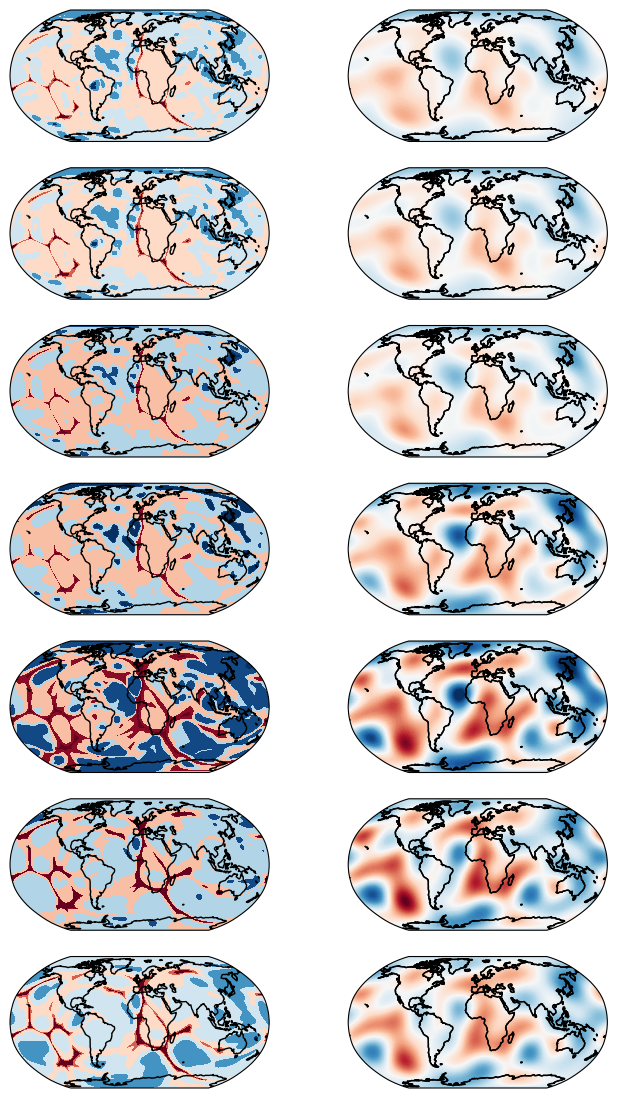

In [ ]:
# Fig. 1a: Workflow plot (Need to rotate plots in PPT)
fig, ax = plt.subplots(7, 2, figsize = (8, 14), subplot_kw=dict(projection=ccrs.Robinson()))
# fig.subplots_adjust(wspace = 0.2, hspace = 0.1)

vtype = 's'
cbar_lim = 2.5

for i, terra in enumerate(terra_vmodels_11.vs_grid[-16:-2:2]):
    index = -16 + 2* i

    # Converting TERRA and SShell velocities as average percentages
    sshellmodel_avg = sshell_vmodel.get_sh_coefs_at_r(6371 - depth[index])
    terra = (terra - sshellmodel_avg[0,0,0] / (2.0 * np.sqrt(np.pi))) / (sshellmodel_avg[0,0,0] / (2.0 * np.sqrt(np.pi)))
    
    sshellmodel_avg /= sshellmodel_avg[0,0,0] / (2.0 * np.sqrt(np.pi))
    sshellmodel_avg[0,0,0] = 0


    x, y, terra_plot = gridded_data(((lon+180)%360)-180, lat, 100 * terra)

    ax[i,0].contourf(x, y, terra_plot, cmap = 'RdBu', transform = ccrs.PlateCarree(), vmin = -cbar_lim, vmax = cbar_lim)
    tomoproxy.plotting.plot_shcoefs(100 * sshellmodel_avg, quantity = f'dV$_{vtype}$ (%)', cmap = 'RdBu',
                                    fig = fig,
                                    ax = ax[i, 1],
                                    vmin = -cbar_lim, vmax = cbar_lim, show_cb = False, projection = ccrs.Robinson())

    ax[i,0].coastlines()
    ax[i,1].coastlines()

if output_figure:
    fig.savefig(os.path.join(outdir, 'workflow_stacks.png'), transparent = True)

/var/folders/cs/4dd1zds94b5c7zcgwb3dbv3c0000gq/T/ipykernel_13668/3735165740.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0,0] = plt.subplot(3,2,(1), projection = 'rectilinear')
/Users/univ4732/anaconda3/envs/lema/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


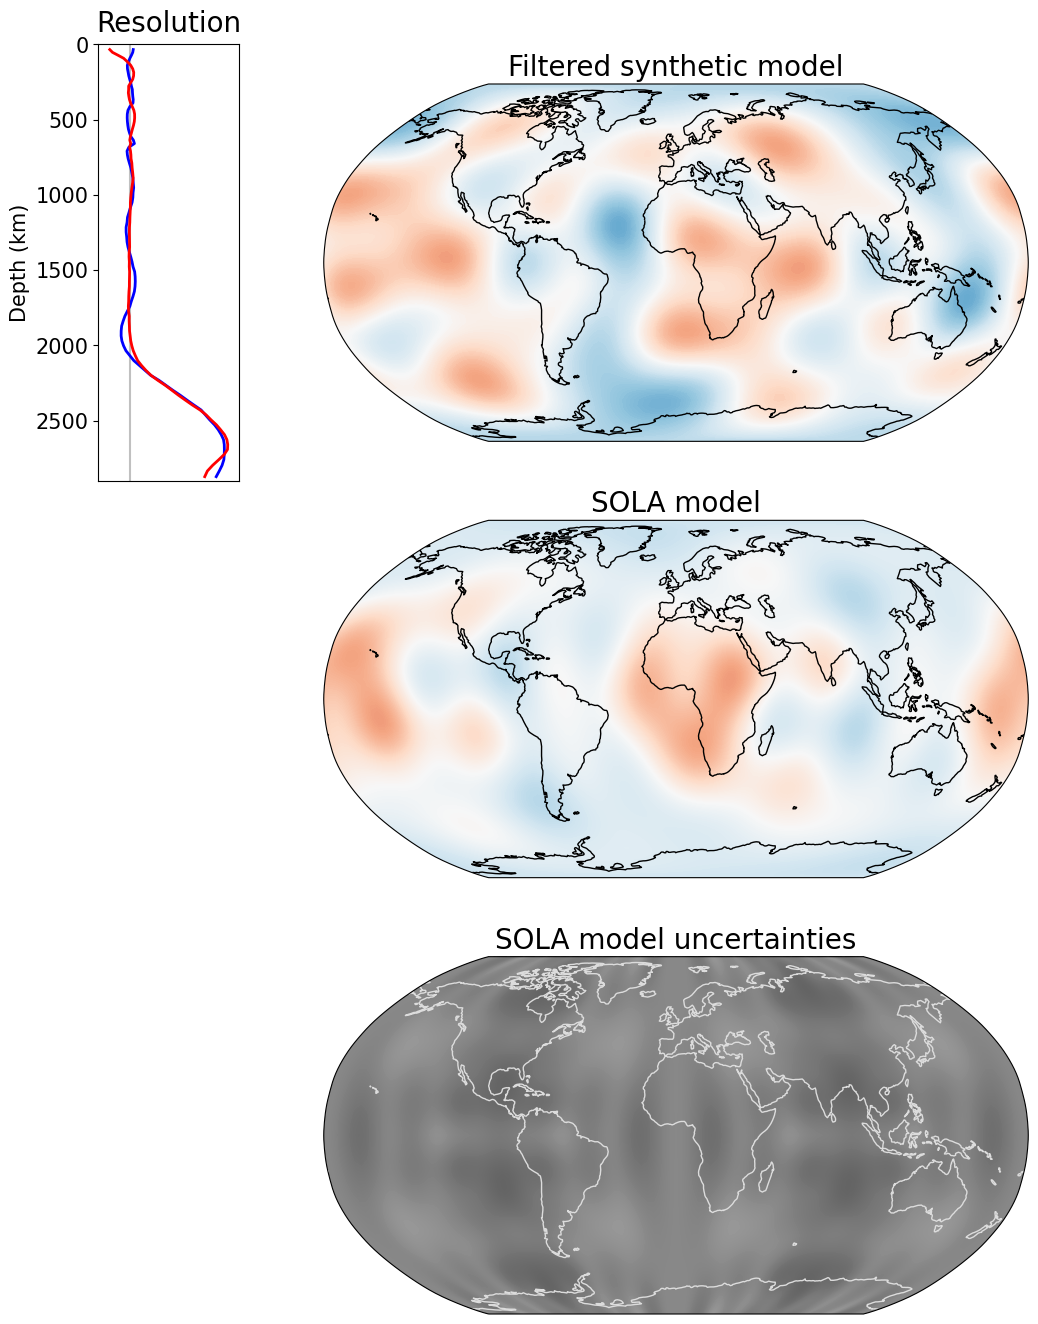

In [ ]:
# Fig. 1b: Workflow plot for tomography part
fig, ax = plt.subplots(3, 2, figsize = (12, 17), gridspec_kw = {'height_ratios': [6, 6, 6], 'width_ratios': [1, 5]}, subplot_kw=dict(projection=ccrs.Robinson()))
fig.subplots_adjust(wspace = 0.2, hspace = 0)
fontsize = 20

vtype = 's'
cbar_lim = [-2.5, 2.5]

# Plot graphs on the right column
ax[0,0] = plt.subplot(3,2,(1), projection = 'rectilinear')
ax[0,0].axvline(0, c = 'silver')
ax[0,0].plot(SOLA_model.spline_vp, 6371 - SOLA_model.depths, 'b', linewidth = 2, label = 'd$\ln V_p$')
ax[0,0].plot(SOLA_model.spline_vs, 6371 - SOLA_model.depths, 'r', linewidth = 2, label = 'd$\ln V_s$')
ax[0,0].set_ylabel('Depth (km)', fontsize= fontsize - 5)
ax[0,0].set_ylim([2900, 0])
ax[0,0].set_xlim([-0.02,0.07])
ax[0,0].set_xticks([])
ax[0,0].tick_params(axis = 'both', labelsize = fontsize-5)
ax[0,0].set_title('Resolution', fontsize = fontsize, y = 1.01)


tomoproxy.plotting.plot_shcoefs(models['pyrolite_ppv_11'].vs, quantity = f'dV$_{vtype}$ (%)', cmap = 'RdBu',
                                    fig = fig,
                                    ax = ax[0,1],
                                    vmin = -2.5, vmax = 2.5, show_cb = False, projection = ccrs.Robinson())
tomoproxy.plotting.plot_shcoefs(SOLA_model.vs, quantity = f'dV$_{vtype}$ (%)', cmap = 'RdBu',
                                    fig = fig,
                                    ax = ax[1,1],
                                    vmin = -2.5, vmax = 2.5, show_cb = False, projection = ccrs.Robinson())
h = tomoproxy.plotting.plot_err_coefs(SOLA_model.vs_err, quantity=f'$\sigma$ V$_{vtype}$',
                                    show_cb=False,
                                    fig = fig,
                                    ax = ax[2,1],
                                    vmax = 0.25, projection=ccrs.Robinson())

ax[0,1].set_title(f'Filtered synthetic model', fontsize = fontsize)
ax[1,1].set_title(f'SOLA model', fontsize = fontsize)
ax[2,1].set_title(f'SOLA model uncertainties', fontsize = fontsize)

# Get rid of empty axes
ax[1,0].set_axis_off()
ax[2,0].set_axis_off()

if output_figure:
    fig.savefig(os.path.join(outdir, 'workflow.png'), transparent = True)

/var/folders/cs/4dd1zds94b5c7zcgwb3dbv3c0000gq/T/ipykernel_29101/742840977.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels()[:-1], fontsize = 15)
/var/folders/cs/4dd1zds94b5c7zcgwb3dbv3c0000gq/T/ipykernel_29101/742840977.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = 15)


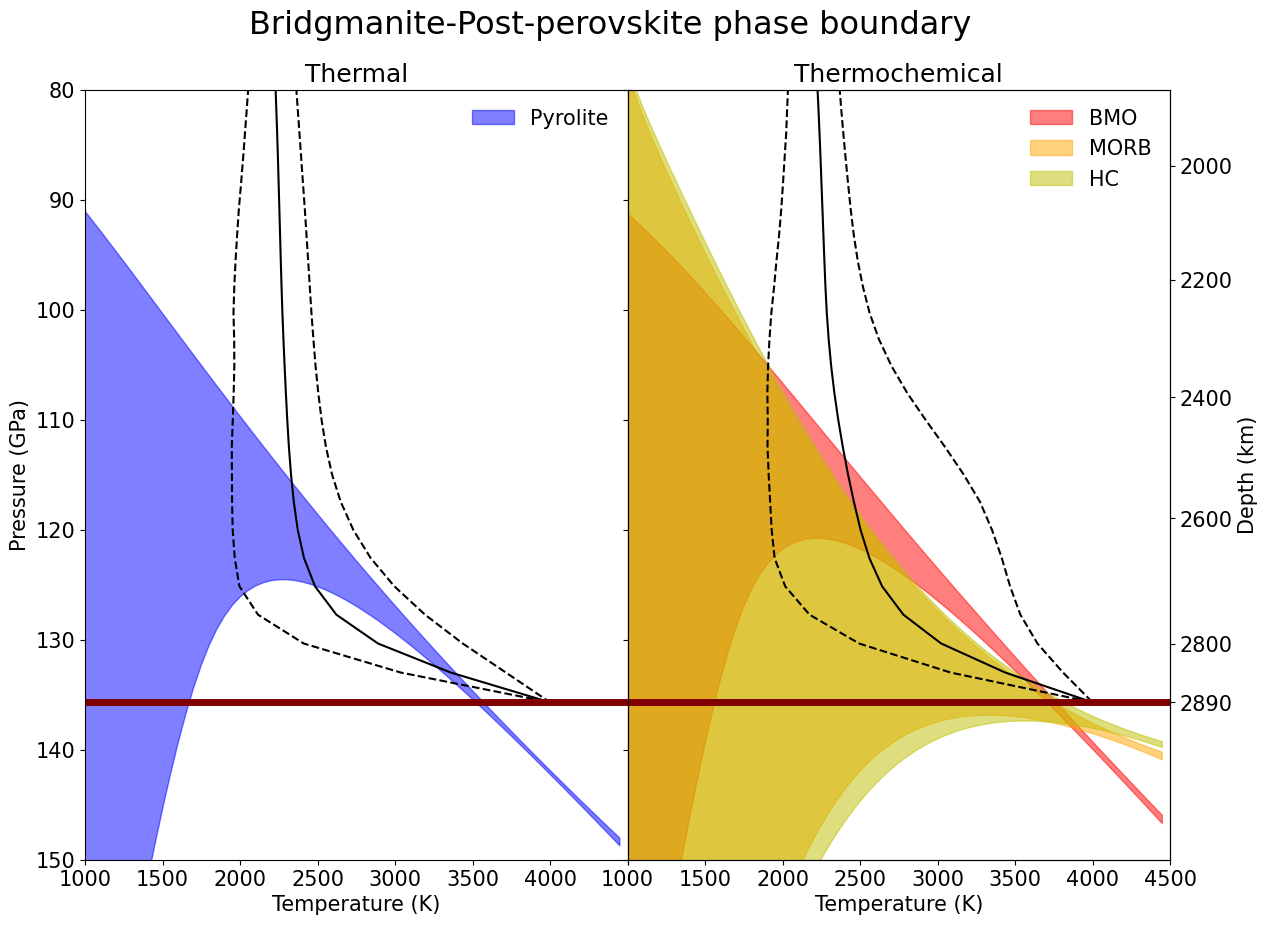

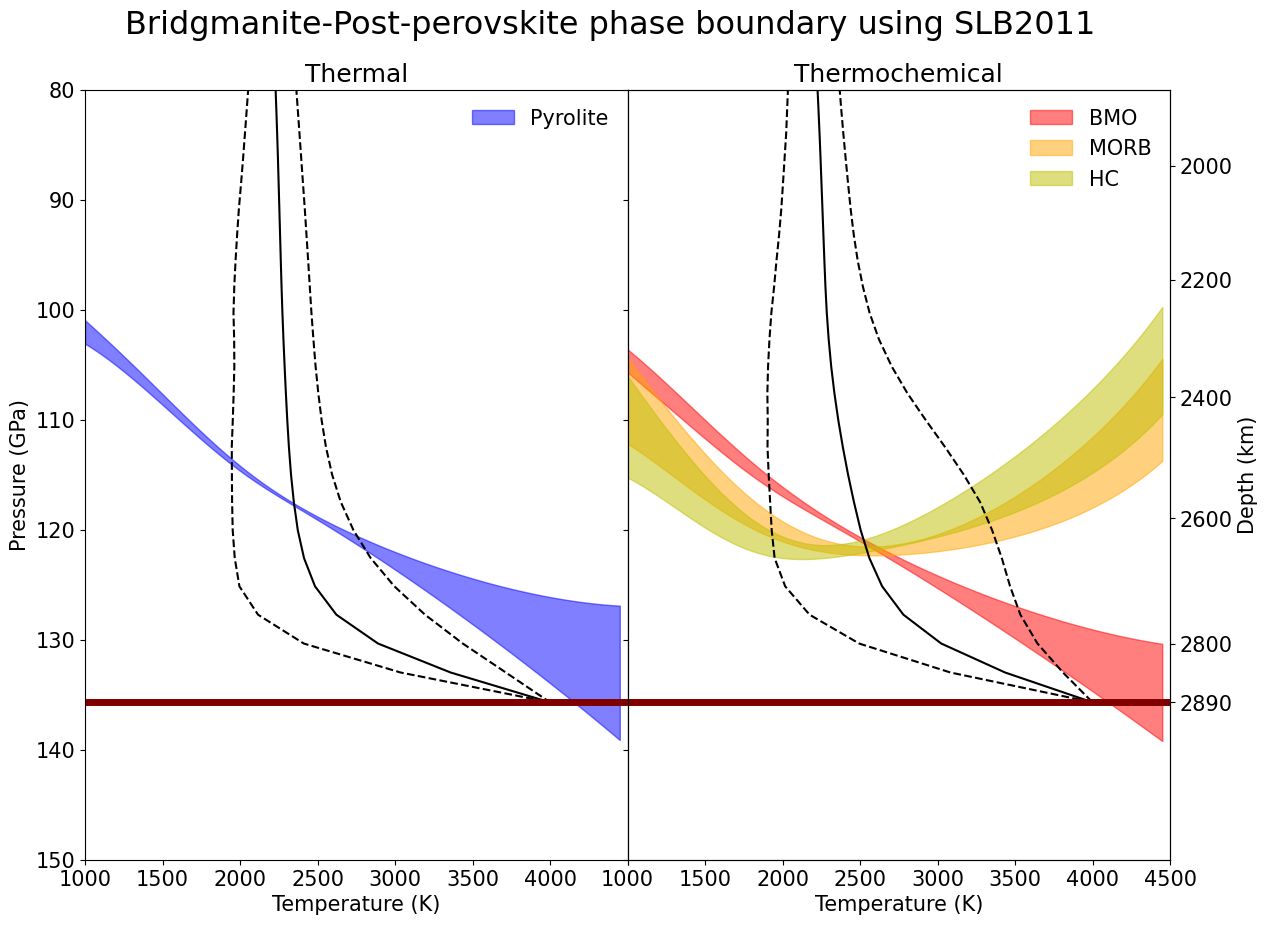

In [ ]:
# Fig. 2: Two-phase region for SLB2022
plot_two_phase_region(phaseboundary['pyrolite_22'].temperatures, phaseboundary, 
                      t_grid, min_model='SLB_2022', output_figure=output_figure)

# Fig. S3: Two-phase region for SLB2022
plot_two_phase_region(phaseboundary['pyrolite_11'].temperatures, phaseboundary, 
                      t_grid, min_model='SLB_2011', output_figure=output_figure)


/var/folders/cs/4dd1zds94b5c7zcgwb3dbv3c0000gq/T/ipykernel_13668/3793437681.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[-1,1] = plt.subplot(3,3,8, projection = 'rectilinear')
/var/folders/cs/4dd1zds94b5c7zcgwb3dbv3c0000gq/T/ipykernel_13668/3793437681.py:49: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[-1,2] = plt.subplot(3,3,9, projection = 'rectilinear')
/var/folders/cs/4dd1zds94b5c7zcgwb3dbv3c0000gq/T/ipykernel_13668/3793437681.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0,0] = plt.subplot(3,3,(1,4), projection = 'rectilinear')
/Users/univ4732/anaconda3/envs/lema/lib/python3.9/si

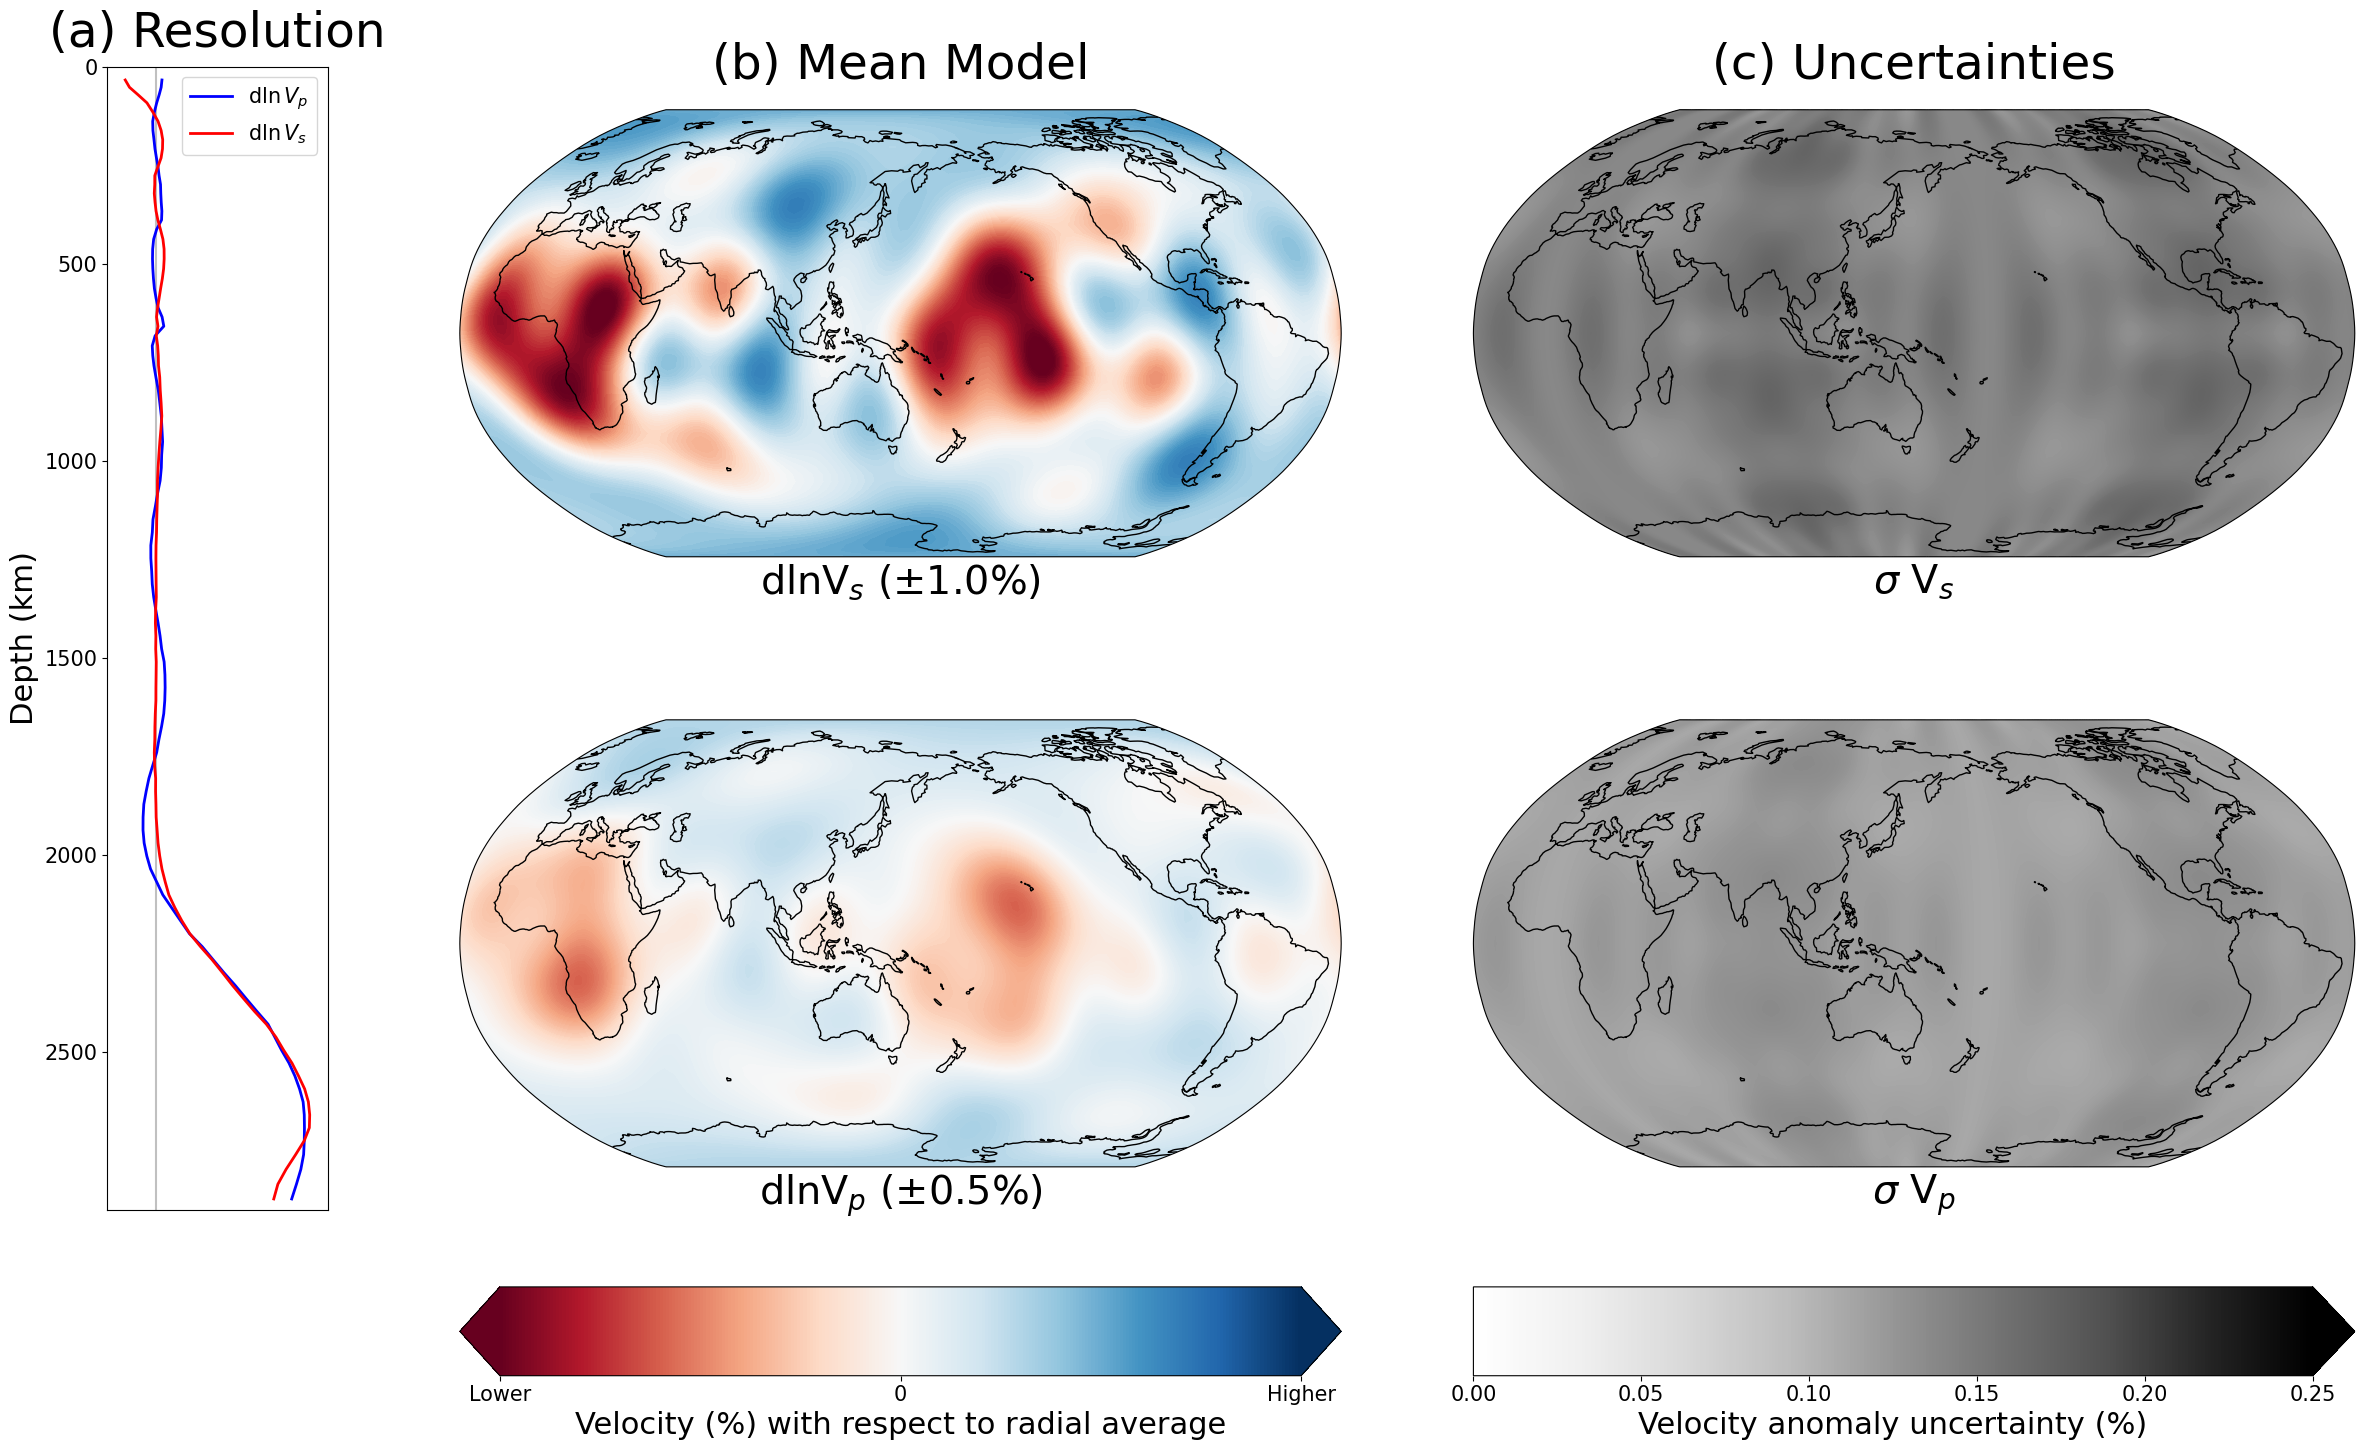

In [ ]:
# Fig. 3: SOLA Model
titlesize = 35
labelsize = 22
ticklabelsize = 15

fig = plot_SOLA_model(SOLA_model, titlesize, labelsize, ticklabelsize)

if output_figure:
    fig.savefig(os.path.join(outdir, 'SOLA_model.png'), transparent = True, bbox_inches = 'tight')
    fig.savefig(os.path.join(outdir, 'SOLA_model.eps'), transparent = True, bbox_inches = 'tight')

/var/folders/cs/4dd1zds94b5c7zcgwb3dbv3c0000gq/T/ipykernel_13668/2362969013.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  v_axis = plt.subplot(6,6, (2,3), projection = ccrs.Robinson(central_longitude = central_longitude))
/var/folders/cs/4dd1zds94b5c7zcgwb3dbv3c0000gq/T/ipykernel_13668/2362969013.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  sigma_axis = plt.subplot(6,6, (4,5), projection = ccrs.Robinson(central_longitude = central_longitude))
/var/folders/cs/4dd1zds94b5c7zcgwb3dbv3c0000gq/T/ipykernel_13668/2362969013.py:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  cb_v_axis = plt.subplot(6

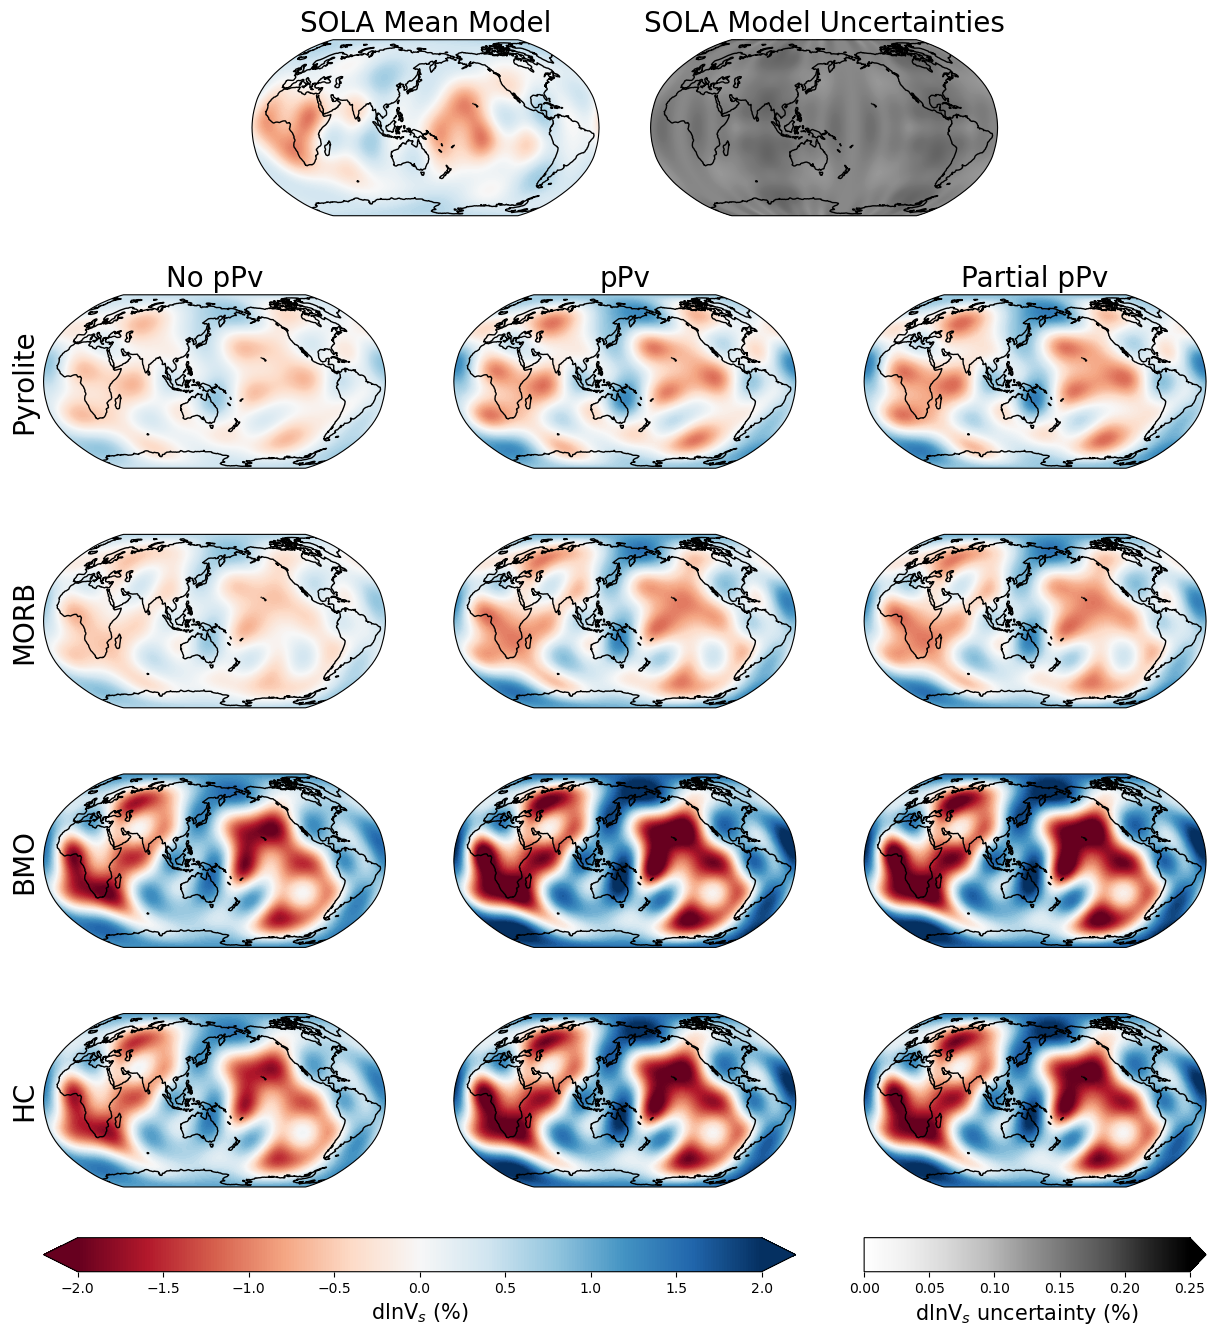

/Users/univ4732/anaconda3/envs/lema/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/univ4732/anaconda3/envs/lema/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/univ4732/anaconda3/envs/lema/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/univ4732/anaconda3/envs/lema/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/univ4732/anaconda3/envs/lema/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/univ4732/anaconda3/envs/lema/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Use

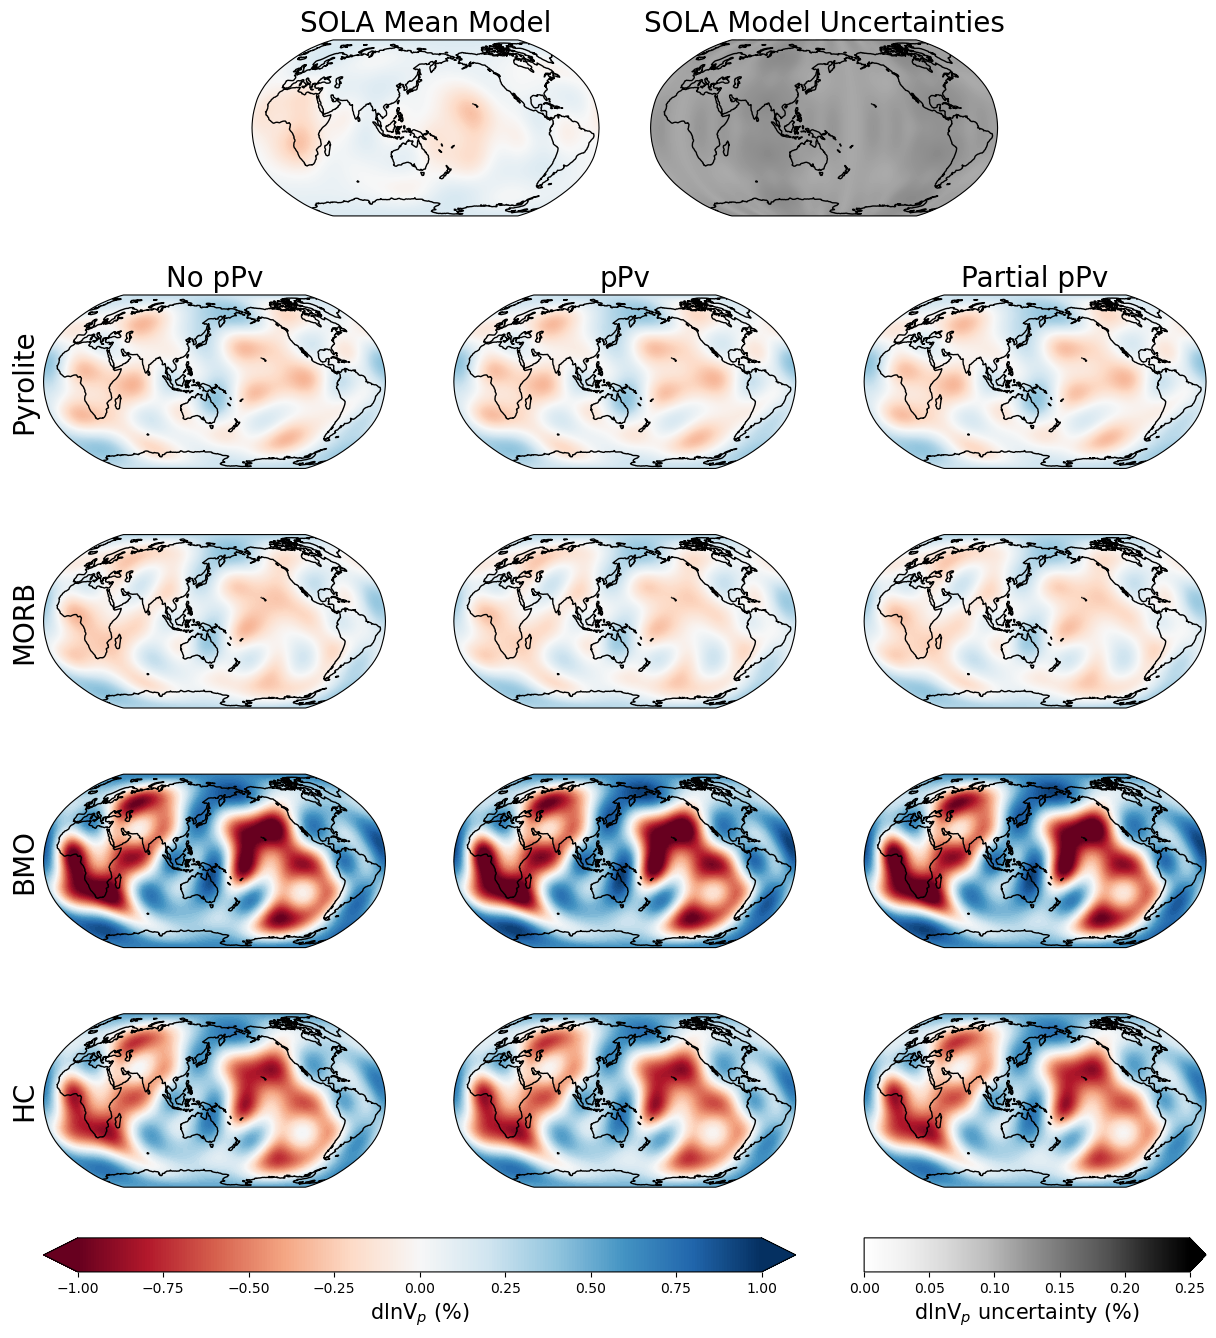

In [ ]:
# Fig 4: V_s slices for SLB2022 model
plot_filtered_synthetic_models(SOLA_model, models, 'vs', 2, "SLB_2022", central_longitude = 150,
                               plot_type = 'poster', outdir = outdir)

# Fig S1: V_p slices for SLB2011 model
plot_filtered_synthetic_models(SOLA_model, models, 'vp', 1, "SLB_2022", central_longitude = 150,
                               plot_type = 'poster', outdir = outdir)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


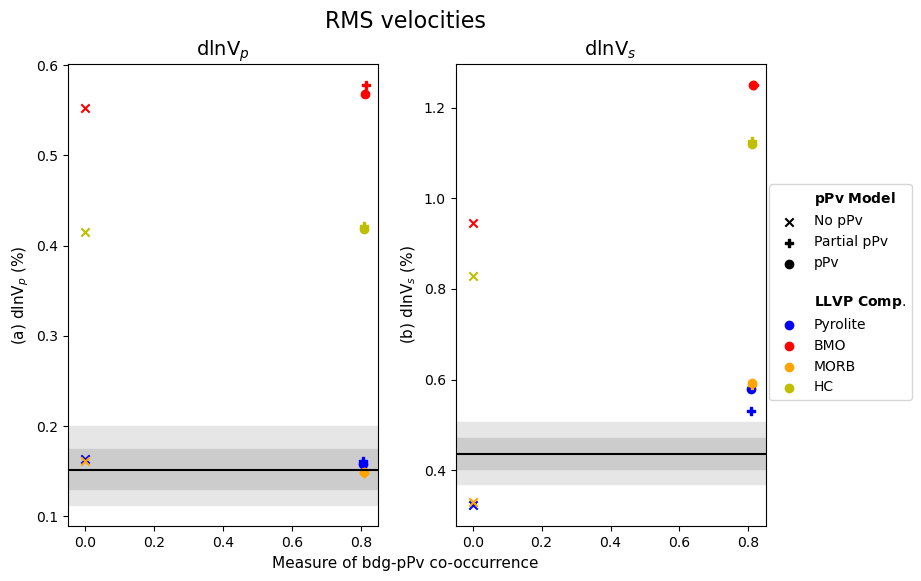

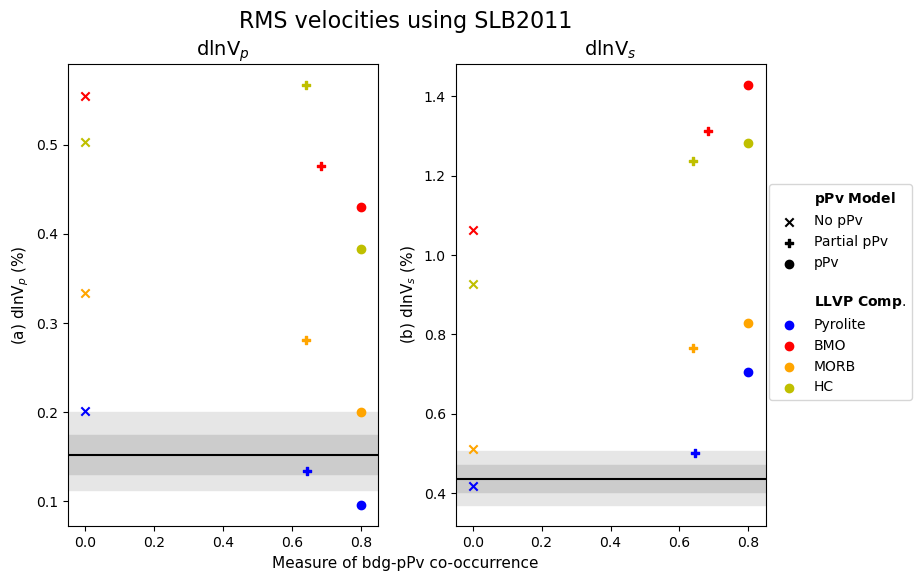

In [ ]:
# Fig 5: RMS dln velocities for SLB2022 model
plot_RMS_velocities(ppv_lateral_frac, models,
                    vp_median, vs_median, 
                    vp_bounds_1, vs_bounds_1, 
                    vp_bounds_2, vs_bounds_2, 
                    outdir=outdir)

# Fig S2: RMS dln velocities for SLB2022 model
plot_RMS_velocities(ppv_lateral_frac, models,
                    vp_median, vs_median, 
                    vp_bounds_1, vs_bounds_1, 
                    vp_bounds_2, vs_bounds_2, 
                    min_model='SLB_2011', outdir=outdir)

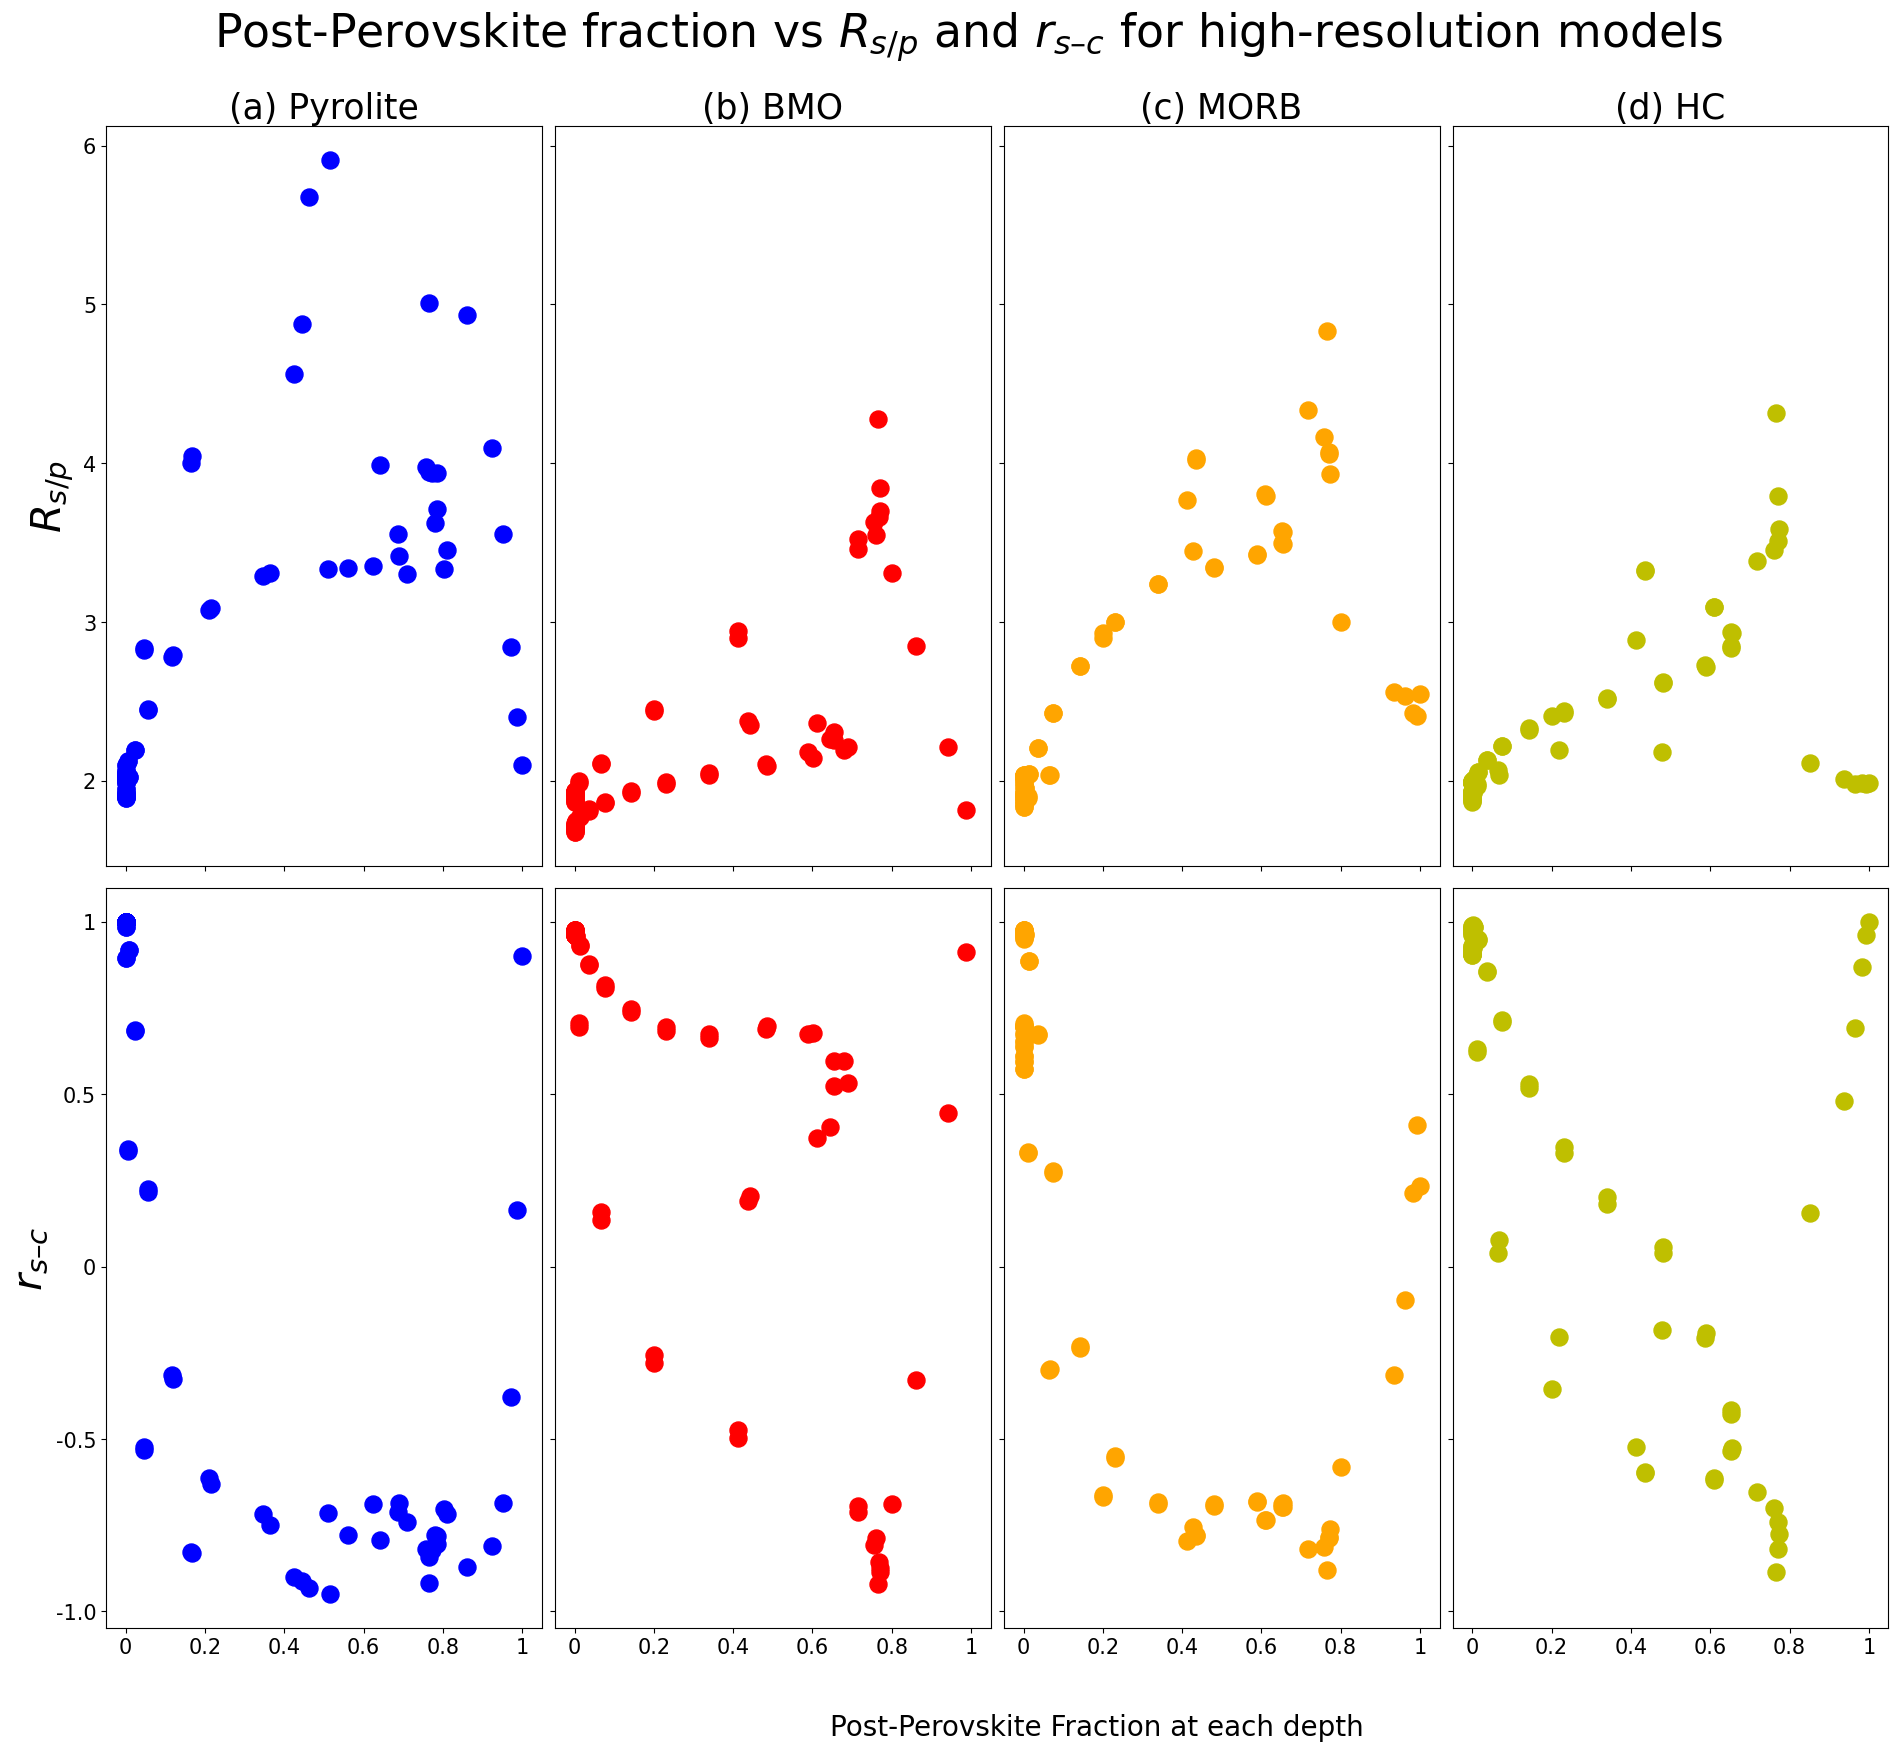

In [ ]:
# Fig 6: post-Perovskite fraction against R_s/p (top) and r_s-c (bottom) at different depths for different compositions (columns)
output_type = 'poster' # or 'presentation'
detail_type = 'simple'
separate_rows = False

if output_type == 'presentation':
    fig, ax = plt.subplots(2,4, figsize = (28, 15), sharey='row', sharex = not separate_rows)
    titlesize = 30
    labelsize = 30
    ticklabelsize = 20
    size = 150
    edgesize = 3
else:
    fig, ax = plt.subplots(2,4, figsize = (23, 19.5), sharey='row', sharex = not separate_rows)
    suptitlesize = 33
    titlesize = 25
    labelsize = 20
    ticklabelsize = 15
    size = 150
    edgesize = 3

if separate_rows:
    fig.subplots_adjust(wspace = 0.03, hspace = 0.35)
else:
    fig.subplots_adjust(wspace = 0.03, hspace = 0.03)

comp_order_ppv = ['royalblue', 'darkblue', 'b', 'tomato', 'darkred', 'r', 
                  'navajowhite', 'chocolate', 'orange', 'palegoldenrod', 'darkgoldenrod', 'y']
m_keys = ['pyrolite_noppv', 'pyrolite_ppv', 'pyrolite_partppv', 'BMO_noppv', 'BMO_ppv', 'BMO_partppv', 
          'MORB_noppv', 'MORB_ppv', 'MORB_partppv', 'HC_noppv', 'HC_ppv', 'HC_partppv']

for i, (c, k) in enumerate(zip(comp_order_ppv, m_keys)):
    if i%3 == 0:
        continue
    
    if detail_type == 'simple':
        ax[0,int(np.floor(i/3)%4)].scatter(ppv_means[k+'_11'][-20:-1], root_terra[12+i, :-1], c = comp_order_ppv[int(3*np.floor(i/3))+2], s = size)
        ax[1,int(np.floor(i/3)%4)].scatter(ppv_means[k+'_11'][-20:-1], vphi_vs_corr_terra[i12+, :-1], c = comp_order_ppv[int(3*np.floor(i/3))+2], s = size)
        ax[0,int(np.floor(i/3)%4)].scatter(ppv_means[k+'_22'][-20:-1], root_terra[i, :-1], c = comp_order_ppv[int(3*np.floor(i/3))+2], s = size)
        ax[1,int(np.floor(i/3)%4)].scatter(ppv_means[k+'_22'][-20:-1], vphi_vs_corr_terra[i, :-1], c = comp_order_ppv[int(3*np.floor(i/3))+2], s = size)
        continue

    ax[0,int(np.floor(i/3)%4)].scatter(ppv_means[k+'_11'][-20:-1], root_terra[12+i, :-1], c = c, s = size)
    ax[1,int(np.floor(i/3)%4)].scatter(ppv_means[k+'_11'][-20:-1], vphi_vs_corr_terra[12+i, :-1], c = c, s = size)
    if output_type == 'presentation':
        ax[0,int(np.floor(i/3)%4)].scatter(ppv_means[k+'_22'][-20:-1], root_terra[i, :-1], c = c, s = size)
        ax[1,int(np.floor(i/3)%4)].scatter(ppv_means[k+'_22'][-20:-1], vphi_vs_corr_terra[i, :-1], c = c, s = size)
    else:
        ax[0,int(np.floor(i/3)%4)].scatter(ppv_means[k+'_22'][-20:-1], root_terra[i, :-1], c = 'none', edgecolors = c, s = size, linewidth = edgesize)
        ax[1,int(np.floor(i/3)%4)].scatter(ppv_means[k+'_22'][-20:-1], vphi_vs_corr_terra[i, :-1], c = 'none', edgecolors = c, s = size, linewidth = edgesize)

ax[0,0].set_ylabel('$R_{s/p}$', fontsize = 1.5 * labelsize)
ax[1,0].set_ylabel('$r_{s–c}$',fontsize = 1.5 * labelsize)
fig.text(0.44, 0.055, 'Post-Perovskite Fraction at each depth', fontsize = labelsize)
if separate_rows:
    fig.text(0.44, 0.50, 'Post-Perovskite Fraction at each depth', fontsize = labelsize)

ax[0,0].set_title('(a) Pyrolite', fontsize = titlesize)
ax[0,1].set_title('(b) BMO', fontsize = titlesize)
ax[0,2].set_title('(c) MORB', fontsize = titlesize)
ax[0,3].set_title('(d) HC', fontsize = titlesize)
ax[0,0].tick_params(axis = 'both', which = 'major', labelsize = ticklabelsize)
ax[1,0].tick_params(axis = 'both', which = 'major', labelsize = ticklabelsize)
ax[1,1].tick_params(axis = 'both', which = 'major', labelsize = ticklabelsize)
ax[1,2].tick_params(axis = 'both', which = 'major', labelsize = ticklabelsize)
ax[1,3].tick_params(axis = 'both', which = 'major', labelsize = ticklabelsize)
ax[1,0].set_xticks([0,0.2,0.4,0.6,0.8,1], labels = ['0','0.2','0.4','0.6','0.8','1'], fontsize = ticklabelsize)
ax[1,1].set_xticks([0,0.2,0.4,0.6,0.8,1], labels = ['0','0.2','0.4','0.6','0.8','1'], fontsize = ticklabelsize)
ax[1,2].set_xticks([0,0.2,0.4,0.6,0.8,1], labels = ['0','0.2','0.4','0.6','0.8','1'], fontsize = ticklabelsize)
ax[1,3].set_xticks([0,0.2,0.4,0.6,0.8,1], labels = ['0','0.2','0.4','0.6','0.8','1'], fontsize = ticklabelsize)
ax[1,0].set_yticks([-1,-0.5,0,0.5,1], labels = ['-1.0','-0.5','0','0.5','1'], fontsize = ticklabelsize)
if separate_rows:
    ax[0,1].tick_params(axis = 'both', which = 'major', labelsize = ticklabelsize)
    ax[0,2].tick_params(axis = 'both', which = 'major', labelsize = ticklabelsize)
    ax[0,3].tick_params(axis = 'both', which = 'major', labelsize = ticklabelsize)
    ax[1,0].set_title('Pyrolite', fontsize = titlesize)
    ax[1,1].set_title('BMO', fontsize = titlesize)
    ax[1,2].set_title('MORB', fontsize = titlesize)
    ax[1,3].set_title('HC', fontsize = titlesize)

# Legend
if output_type == 'presentation':
    pass
elif detail_type == 'simple':
    fig.suptitle('Post-Perovskite fraction vs $R_{s/p}$ and $r_{s–c}$ for high-resolution models', y = 0.94, fontsize = suptitlesize)
else:
    ax[1,0].scatter([-1,-1],[0,0], label = 'Partial pPv', c = 'grey', s = size)
    ax[1,0].scatter([-1,-1],[0,0], label = 'pPv', c = 'black', s = size)
    ax[1,0].scatter([-1,-1],[0,0], label = 'SLB 2011', c = 'k', marker = 'o', s = size)
    ax[1,0].scatter([-1,-1],[0,0], label = 'SLB 2022', c = 'none', edgecolor= 'k', marker = 'o', s = size, linewidth = edgesize)
    ax[1,0].set_xlim([-0.05, 1.05])
    fig.legend(loc = 'lower center', fontsize = ticklabelsize, bbox_to_anchor = (0.5, -0.0), ncols = 4)
    fig.suptitle('Post-Perovskite fraction vs $R_{s/p}$ and $r_{s–c}$ for high-resolution models', y = 0.94, fontsize = suptitlesize)

if output_figure:
    fig.savefig(os.path.join(outdir, 'ratios_unfiltered.png'), transparent = True, bbox_inches = 'tight')
    fig.savefig(os.path.join(outdir, 'ratios_unfiltered.eps'), transparent = True, bbox_inches = 'tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


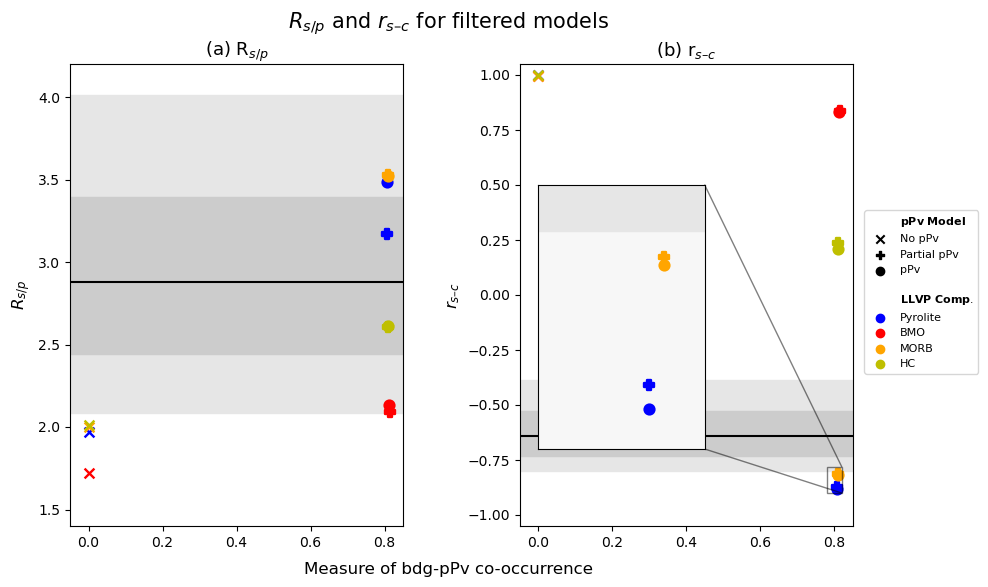

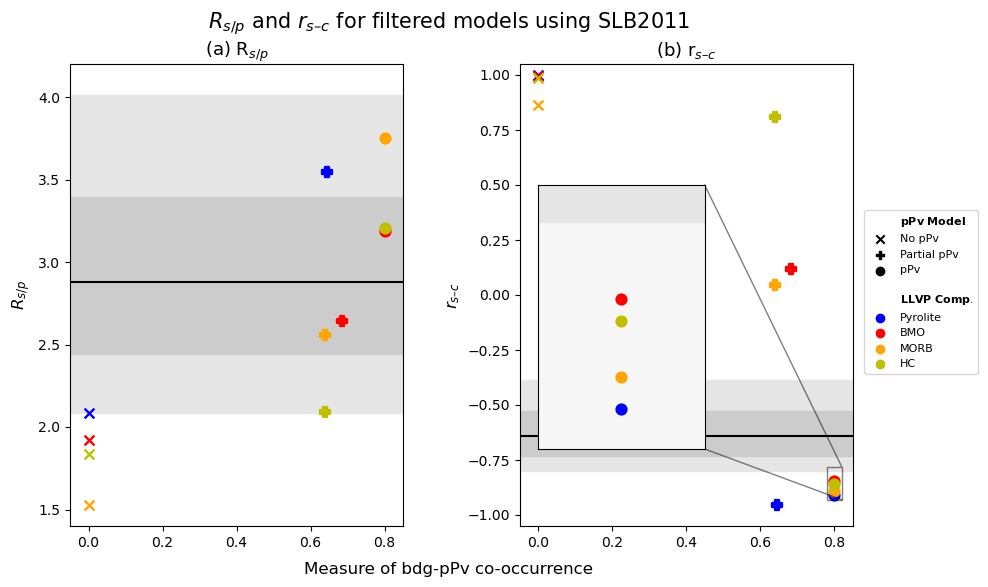

In [ ]:
# Fig 7: Filtered R_s/p (top) and r_s-c (bottom) for SLB2022
plot_ratios_and_corr(ppv_lateral_frac, root, vphi_vs_corr, 
                     r_median, corr_median, 
                     r_bounds_1, corr_bounds_1, 
                     r_bounds_2, corr_bounds_2, 
                     min_model='SLB_2022')

# Fig S4: Filtered R_s/p (top) and r_s-c (bottom) for SLB2022
plot_ratios_and_corr(ppv_lateral_frac, root, vphi_vs_corr, 
                     r_median, corr_median, 
                     r_bounds_1, corr_bounds_1, 
                     r_bounds_2, corr_bounds_2, 
                     min_model='SLB_2011')

/var/folders/cs/4dd1zds94b5c7zcgwb3dbv3c0000gq/T/ipykernel_29101/2536835656.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0,-1] = plt.subplot(6, 5, (5,25), projection = 'rectilinear')
/var/folders/cs/4dd1zds94b5c7zcgwb3dbv3c0000gq/T/ipykernel_29101/2536835656.py:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[-1,0] = plt.subplot(6,5,(26,28), projection = 'rectilinear')
/var/folders/cs/4dd1zds94b5c7zcgwb3dbv3c0000gq/T/ipykernel_29101/2536835656.py:67: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[-1,2] = plt.subplot(6,5,29, projection = 'rectilinear')
/Users/univ4732/anaconda3/envs/lema/lib/p

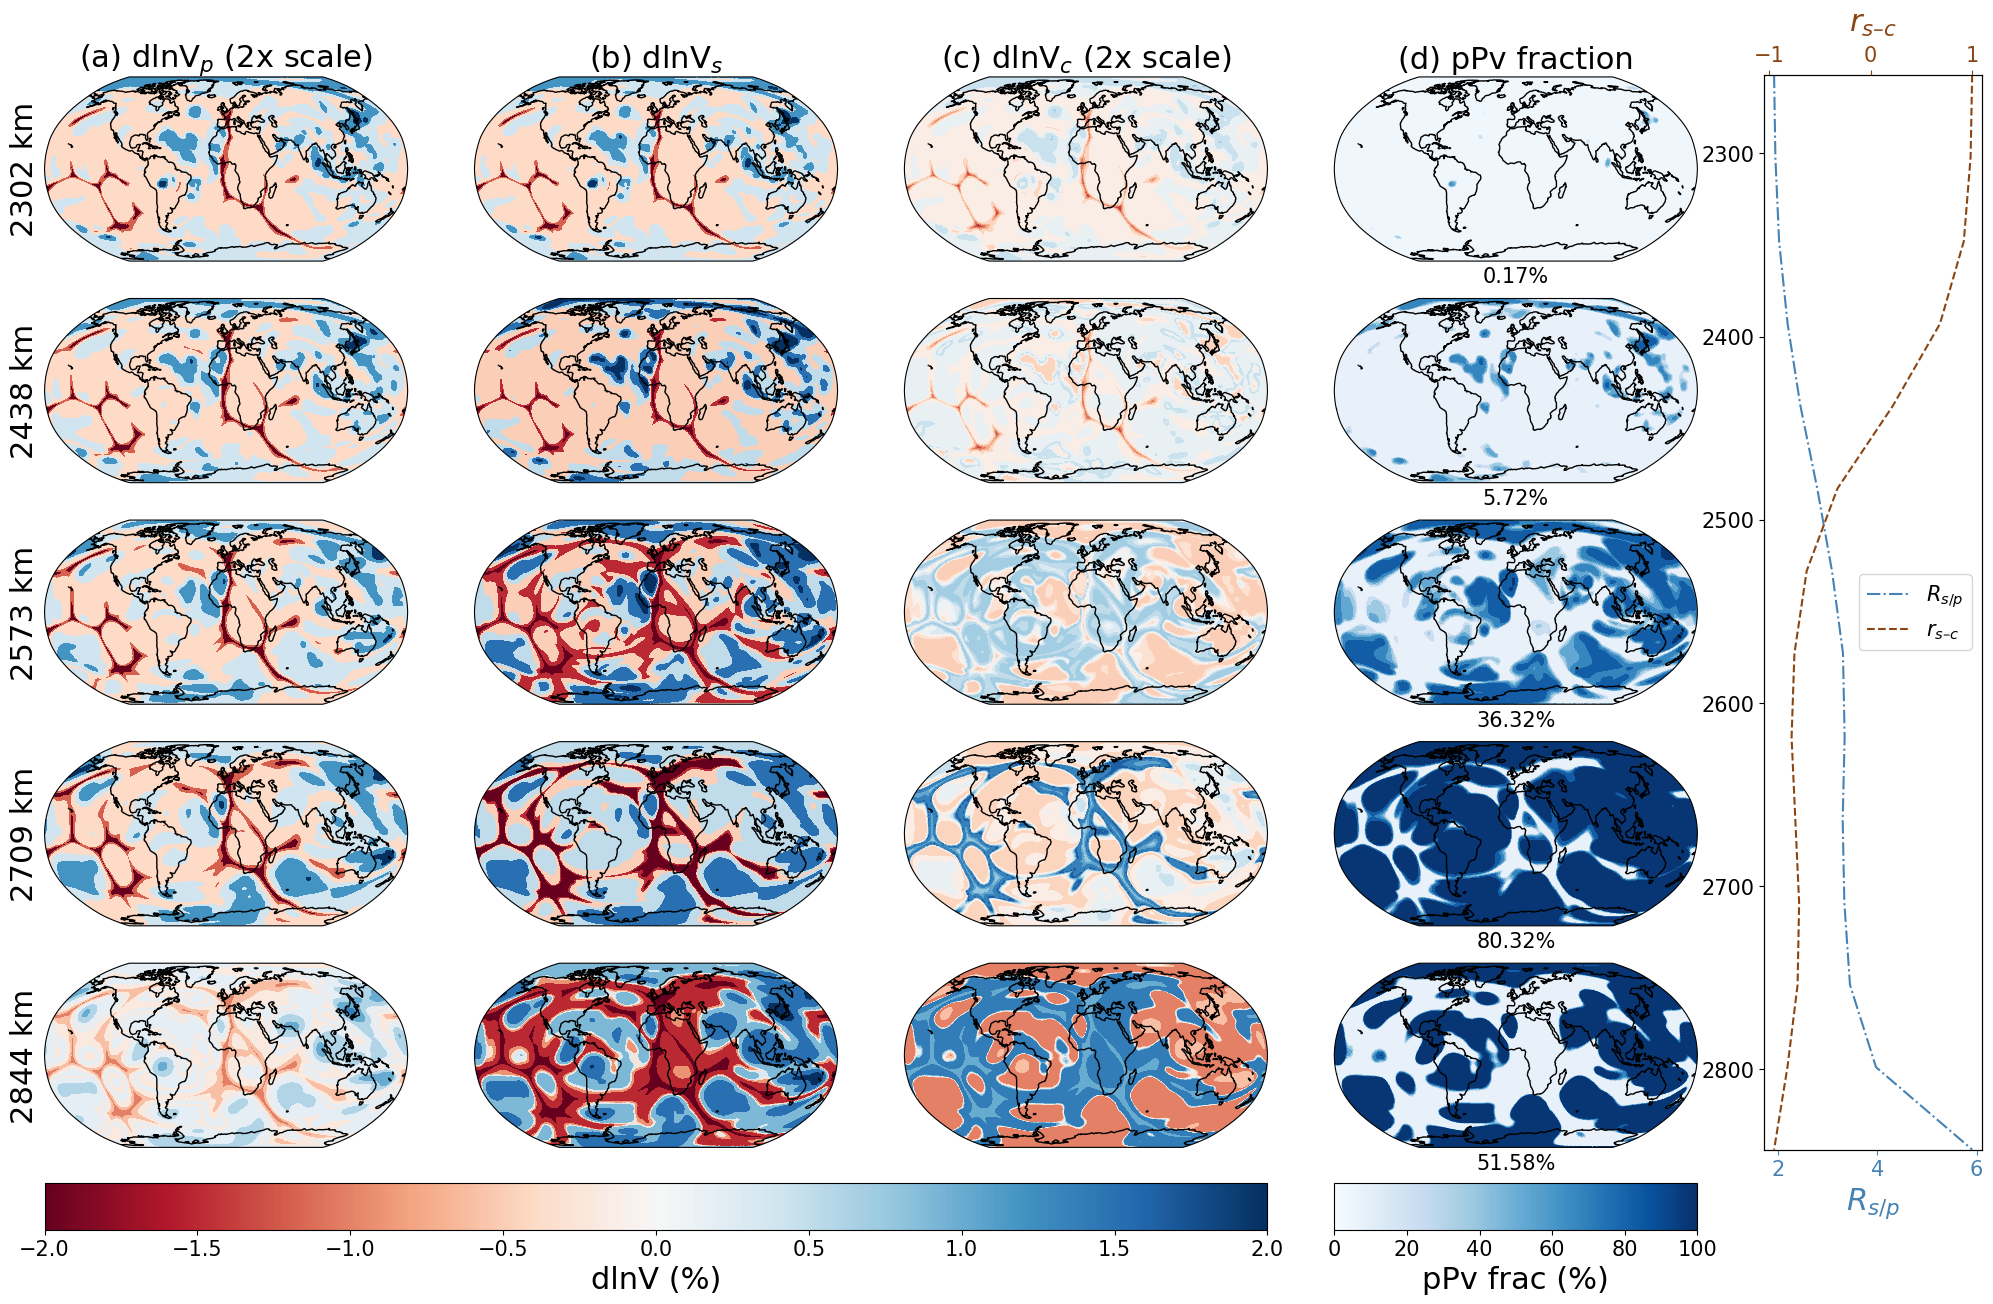

In [ ]:
# Fig 8: Depth plots to show co-occurrence region
labelsize = 22
ticklabelsize = 15

start_depth_index = 37

fig, ax = plt.subplots(6, 5, subplot_kw=dict(projection=ccrs.Robinson()), gridspec_kw = {'height_ratios': [6, 6, 6, 6, 6, 1.5], 'width_ratios': [5, 5, 5, 5, 3]}, figsize = (25,15))
for i in range(5):
    x, y, vp_plot = gridded_data(lon, lat, terra_vmodels.vp_grid[start_depth_index+3*i])
    vp_plot = 100 * (vp_plot - np.mean(vp_plot)) / np.mean(vp_plot)
    ax[i,0].contourf(x, y, vp_plot, cmap = 'RdBu', transform = ccrs.PlateCarree(), vmin = -1, vmax = 1)

    x, y, vs_plot = gridded_data(lon, lat, terra_vmodels.vs_grid[start_depth_index+3*i])
    vs_plot = 100 * (vs_plot - np.mean(vs_plot)) / np.mean(vs_plot)
    ax[i,1].contourf(x, y, vs_plot, cmap = 'RdBu', transform = ccrs.PlateCarree(), vmin = -2, vmax = 2)

    x, y, vphi_plot = gridded_data(lon, lat, terra_vmodels.vphi_grid[start_depth_index+3*i])
    vphi_plot = 100 * (vphi_plot - np.mean(vphi_plot)) / np.mean(vphi_plot)
    ax[i,2].contourf(x, y, vphi_plot, cmap = 'RdBu', transform = ccrs.PlateCarree(), vmin = -1, vmax = 1)

    x, y, ppv_plot = gridded_data(lon, lat, ppv_state_all['pyrolite_ppv_22'][start_depth_index+3*i])
    ax[i,3].contourf(x, y, ppv_plot, cmap = 'Blues', transform = ccrs.PlateCarree(), vmin = 0, vmax = 1)
    ax[i,3].set_xlabel(f'{np.round(100 * ppv_means["pyrolite_ppv_22"][start_depth_index+3*i], 2)}%', fontsize = ticklabelsize)
    ax[i,3].set_xticks([])

    ax[i,0].set_ylabel(f'{int(depth[start_depth_index+3*i])} km', fontsize = labelsize)
    ax[i,0].set_yticks([])

for rows in ax[:-1]:
    for axes in rows:
        axes.coastlines()

ax[0,0].set_title('(a) dlnV$_p$ (2x scale)', fontsize = labelsize)
ax[0,1].set_title('(b) dlnV$_s$', fontsize = labelsize)
ax[0,2].set_title('(c) dlnV$_c$ (2x scale)', fontsize = labelsize)
ax[0,3].set_title('(d) pPv fraction', fontsize = labelsize)

# Plot R and correlation
color_Rsp = 'steelblue'
color_rsc = 'saddlebrown'
ax[0,-1] = plt.subplot(6, 5, (5,25), projection = 'rectilinear')
l1 = ax[0,-1].plot(root_terra[13, -15:-1], depth[-15:-1], linestyle = '-.', c=color_Rsp, label='$R_{s/p}$')
ax[0,-1].set_xlabel('$R_{s/p}$', fontsize = labelsize)
ax2 = ax[0,-1].twiny()
l2 = ax2.plot(vphi_vs_corr_terra[13, -15:-1], depth[-15:-1], linestyle = '--', c=color_rsc, label = '$r_{s–c}$')
ax2.set_xlabel('$r_{s–c}$', fontsize = labelsize, labelpad=10)
lns = l1 + l2
labs = [l.get_label() for l in lns]
ax[0,-1].legend(lns, labs, loc = 'center right', fontsize = ticklabelsize)
ax[0,-1].set_ylim([depth[-2], depth[-15]])
ax[0,-1].tick_params(axis = 'both', which = 'major', labelsize = ticklabelsize)
ax[0,-1].tick_params(axis= 'x', colors = color_Rsp)
ax[0,-1].xaxis.label.set_color(color_Rsp)
ax2.tick_params(axis = 'both', which = 'major', labelsize = ticklabelsize)
ax2.tick_params(axis= 'x', colors = color_rsc)
ax2.xaxis.label.set_color(color_rsc)
ax[-1,-1].set_axis_off()

# Plot Colorbars
ax[-1,0] = plt.subplot(6,5,(26,28), projection = 'rectilinear')
cb = plt.cm.ScalarMappable(cmap = 'RdBu')
cb.set_clim(-2, 2)
h = fig.colorbar(cb, cax = ax[-1,0], orientation = 'horizontal')
h.set_label('dlnV (%)', size=labelsize)
h.ax.tick_params(labelsize = ticklabelsize)

ax[-1,2] = plt.subplot(6,5,29, projection = 'rectilinear')
cb = plt.cm.ScalarMappable(cmap = 'Blues')
cb.set_clim(0, 100)
h2 = fig.colorbar(cb, cax = ax[-1,2], orientation = 'horizontal')
h2.set_label('pPv frac (%)', size=labelsize)
h2.ax.tick_params(labelsize = ticklabelsize)

if output_figure:
    fig.savefig(outdir + 'ppv_proof_depth_slices.png', transparent = True, bbox_inches = 'tight')
    fig.savefig(outdir + 'ppv_proof_depth_slices.eps', transparent = True, bbox_inches = 'tight')


# Figure showing V_s slices for SLB-2022 model with only bottom 200km dense material
plot_filtered_synthetic_models(SOLA_model, models_200, 'vs', 2, "SLB_2022", central_longitude = 150,
                               plot_type = 'poster', outdir = outdir)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


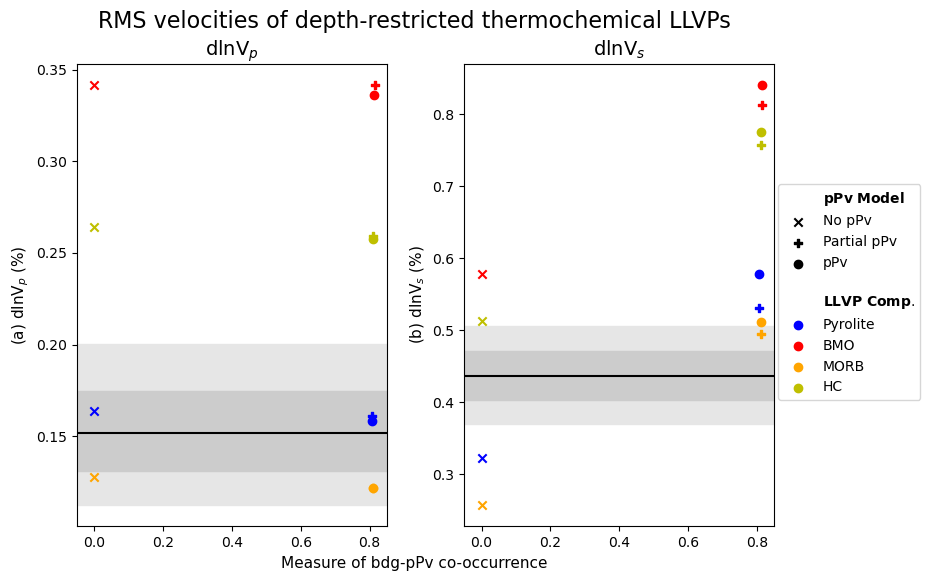

In [ ]:
# Fig S5: RMS dln velocities for bottommost 200km thermochemical case
plot_RMS_velocities(ppv_lateral_frac, models_200,
                    vp_median, vs_median, 
                    vp_bounds_1, vs_bounds_1, 
                    vp_bounds_2, vs_bounds_2, 
                    outdir=outdir, thermochemical_bottom=True)